In [103]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from AnalyticCoolingCurves import *
from unpackConfigurations import unpackConfiguration
from unpackConfigurationsMK import unpackConfigurationMK
import ThermalFrontFormulation as TF
from matplotlib.collections import LineCollection
import os
import pickle as pkl
from LRBv2 import LRBv2
import matplotlib as mpl
import copy
from LengyelReinkeFormulation import *
import ThermalFrontFormulation as TF
import colorcet as cc
from scipy import interpolate
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter, MultipleLocator, FormatStrFormatter, AutoMinorLocator

from DLScommonTools import *

%load_ext autoreload
%autoreload 2

set_matplotlib_defaults()

profile_labels = {"Tprofiles":"$T\ [eV]$", "Qprofiles":"$q\ [Wm^{-2}]$", "Rprofiles":"$Q_{rad}\ [Wm^{-3}]$"}
profile_names = {"Tprofiles":"Temperature profiles", "Qprofiles":"Heat flux density profiles", "Rprofiles":"Radiation profiles"}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# IO

In [2]:
gridFile = r"C:\Users\Mike\OneDrive\Project\DLS\STEPv10\drsep0mm\balance_v10.nc"

list_sides = ["iu", "ou"]
data = dict()
sepadd = 2
res = 500

for side in list_sides:
    data[side] = unpackConfigurationMK(
        File = gridFile, Type = side, sepadd = 2, resolution = res, convention = "target_to_midplane")

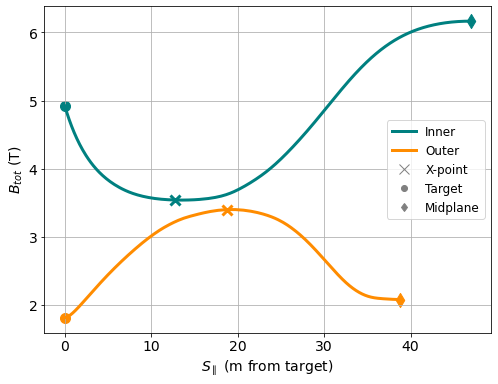

In [3]:
fig, ax = plt.subplots()
colors = mike_cmap(2)
labels = {"ou":"Outer", "iu":"Inner"}
size = 100
for i, side in enumerate(["iu", "ou"]):
    d = data[side]
    Xpoint = d["Xpoint"]
    ax.plot(d["S"], d["Btot"], color = colors[i], label = labels[side])
    ax.scatter(d["S"][Xpoint], d["Btot"][Xpoint], color = colors[i], marker = "x", s = size)
    ax.scatter(d["S"][0], d["Btot"][0], color = colors[i], marker = "o", s = size)
    ax.scatter(d["S"][-1], d["Btot"][-1], color = colors[i], marker = "d", s = size)

ax.set_xlabel("$S_{\parallel}$ (m from target)")
ax.set_ylabel("$B_{tot}$ (T)")
ax.legend()

h,l = ax.get_legend_handles_labels()
extra_handles = [
    mpl.lines.Line2D([0], [0], color = "grey", marker = "x", linewidth=0, label = "X-point", markersize = 10),
    mpl.lines.Line2D([0], [0], color = "grey", marker = "o", linewidth=0, label = "Target"),
    mpl.lines.Line2D([0], [0], color = "grey", marker = "d", linewidth=0, label = "Midplane")]

ax.legend(fontsize = 12, handles = h+extra_handles)

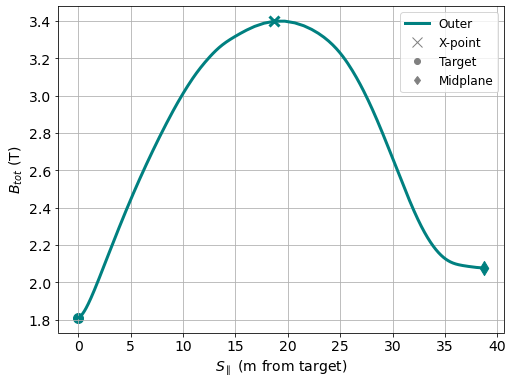

In [4]:
fig, ax = plt.subplots()
colors = mike_cmap(2)
labels = {"ou":"Outer", "iu":"Inner"}
size = 100
for i, side in enumerate(["ou"]):
    d = data[side]
    Xpoint = d["Xpoint"]
    ax.plot(d["S"], d["Btot"], color = colors[i], label = labels[side])
    ax.scatter(d["S"][Xpoint], d["Btot"][Xpoint], color = colors[i], marker = "x", s = size)
    ax.scatter(d["S"][0], d["Btot"][0], color = colors[i], marker = "o", s = size)
    ax.scatter(d["S"][-1], d["Btot"][-1], color = colors[i], marker = "d", s = size)



ax.set_xlabel("$S_{\parallel}$ (m from target)")
ax.set_ylabel("$B_{tot}$ (T)")
ax.legend()

h,l = ax.get_legend_handles_labels()
extra_handles = [
    mpl.lines.Line2D([0], [0], color = "grey", marker = "x", linewidth=0, label = "X-point", markersize = 10),
    mpl.lines.Line2D([0], [0], color = "grey", marker = "o", linewidth=0, label = "Target"),
    mpl.lines.Line2D([0], [0], color = "grey", marker = "d", linewidth=0, label = "Midplane")]

ax.legend(fontsize = 12, handles = h+extra_handles)

In [29]:
list_BxBt_scales2 = np.append(np.linspace(0.25, 1.0, 7), np.linspace(1.0, 2.5, 7)[1:])
list_Lc_scales2 = np.append(np.linspace(0.25, 1.0, 7), np.linspace(1.0, 2.5, 7)[1:])

# Flux Expansion Scaling

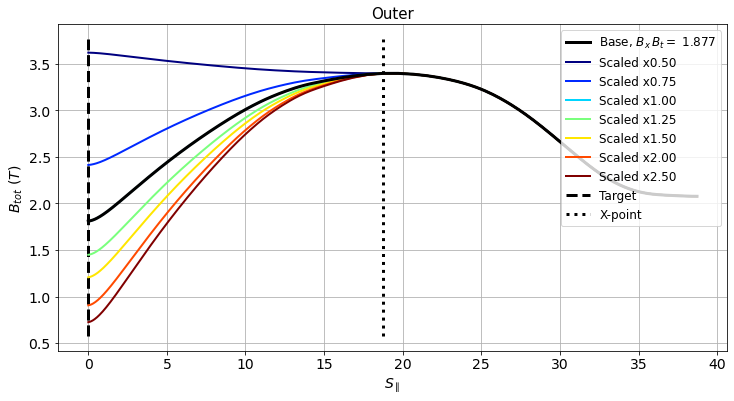

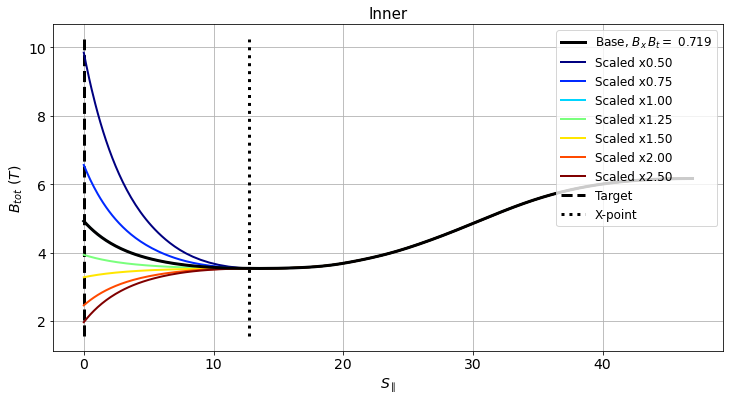

In [55]:
d = data["iu"]
divertor_labels = {"ou": "Outer", "iu": "Inner"}
for side in ["ou", "iu"]:
    d = data[side]
    BxBt_base = d["Btot"][d["Xpoint"]] / d["Btot"][0]
    list_BxBt = [0.5, 0.75, 1, 1.25, 1.5, 2.0, 2.5]

    cmap = plt.get_cmap("jet")
    colors = make_colors(len(list_BxBt), cmap)

    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(d["S"], d["Btot"], color = "black", linewidth = 3, label = "Base, $B_x\/B_t=$ {:.3f}".format(BxBt_base), zorder = 5)

    for i, BxBt in enumerate(list_BxBt):
        new_Btot = scale_BxBt(d["Btot"], d["Xpoint"], scale_factor = BxBt)
        ax.plot(d["S"], new_Btot, label = "Scaled x{:.2f}".format(BxBt), color = colors[i], linewidth = 2)

    ylims = ax.axes.get_ylim()
    ax.vlines(0, ylims[0], ylims[1], color = "black", linestyle = "dashed", label = "Target", linewidth = 3)
    ax.vlines(d["S"][d["Xpoint"]], ylims[0], ylims[1], color = "black", linestyle = "dotted",linewidth =3,  label = "X-point")

    ax.set_title(divertor_labels[side], fontsize = 15)
    ax.legend(loc="upper right", fontsize = 12)
    ax.set_xlabel("$S_{\parallel}$"); 
    ax.set_ylabel("$B_{tot}\ (T)$")



# Connection length scaling

Text(0, 0.5, '$B_{tot}\\ (T)$')

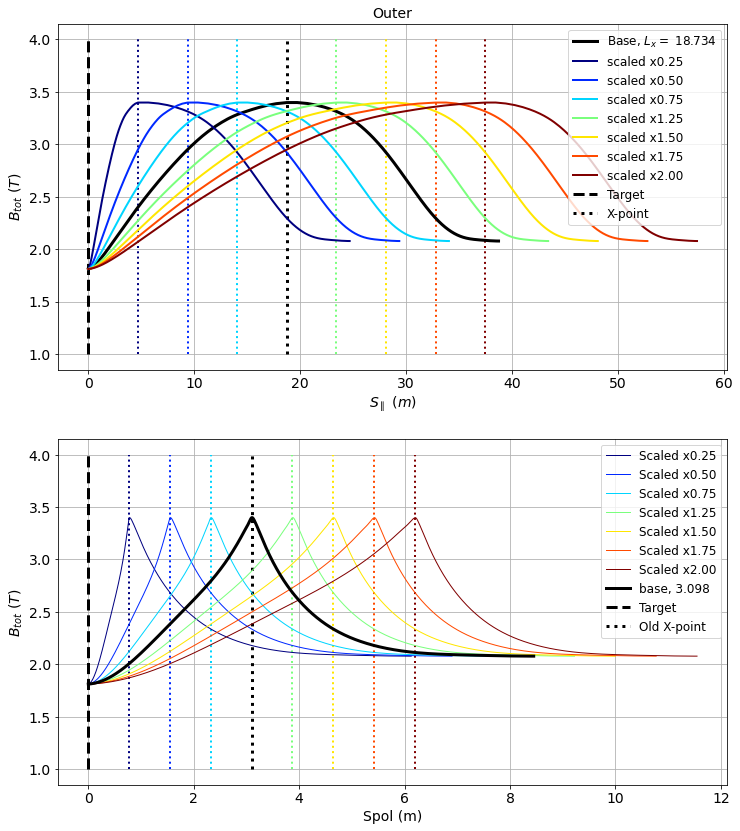

In [56]:
d = data["ou"]

fig, axes = plt.subplots(2,1, figsize=(12,14))

Lc_scale_list = [0.25, 0.5, 0.75, 1.25, 1.50, 1.75, 2.0]

ylims = [1,4]
cmap = plt.get_cmap("jet")
colors = make_colors(len(Lc_scale_list), cmap)

axes[0].plot(d["S"], d["Btot"], color = "black", linewidth = 3, label = "Base, $L_x=$ {:.3f}".format(d["S"][d["Xpoint"]]))

for i, Lc_scale in enumerate(Lc_scale_list):
    S_new, Spol_new = scale_Lc(d["S"], d["Spol"], d["Xpoint"], scale_factor = Lc_scale)
    axes[0].plot(S_new, d["Btot"], linewidth = 2, label = "scaled x{:.2f}".format(Lc_scale), color = colors[i])
    axes[1].plot(Spol_new, d["Btot"], linewidth = 1, label = "Scaled x{:.2f}".format(Lc_scale), color = colors[i])
    
    axes[0].vlines(S_new[d["Xpoint"]], ylims[0], ylims[1], color = colors[i], linestyle = "dotted",linewidth =2)
    axes[1].vlines(Spol_new[d["Xpoint"]], ylims[0], ylims[1], color = colors[i], linestyle = "dotted",linewidth =2)
    

ax = axes[0]

ax.vlines(0, ylims[0], ylims[1], color = "black", linestyle = "dashed", label = "Target", linewidth = 3)
ax.vlines(d["S"][d["Xpoint"]], ylims[0], ylims[1], color = "black", linestyle = "dotted",linewidth =3,  label = "X-point")
ax.set_title("Outer")
ax.legend(loc="upper right",fontsize = 12)
ax.set_xlabel("$S_{\parallel}\ (m)$"); 
ax.set_ylabel("$B_{tot}\ (T)$")

ax = axes[1]
ax.plot(d["Spol"], d["Btot"], color = "black", linewidth = 3, label = "base, {:.3f}".format(d["Spol"][d["Xpoint"]]))
ax.vlines(0, ylims[0], ylims[1], color = "black", linestyle = "dashed", label = "Target", linewidth = 3)
ax.vlines(d["Spol"][d["Xpoint"]], ylims[0], ylims[1], color = "black", linestyle = "dotted",linewidth =3,  label = "Old X-point")
ax.legend(loc="upper right",fontsize = 12)
ax.set_xlabel("Spol (m)"); 
ax.set_ylabel("$B_{tot}\ (T)$")



# Scaling iu to be like ou

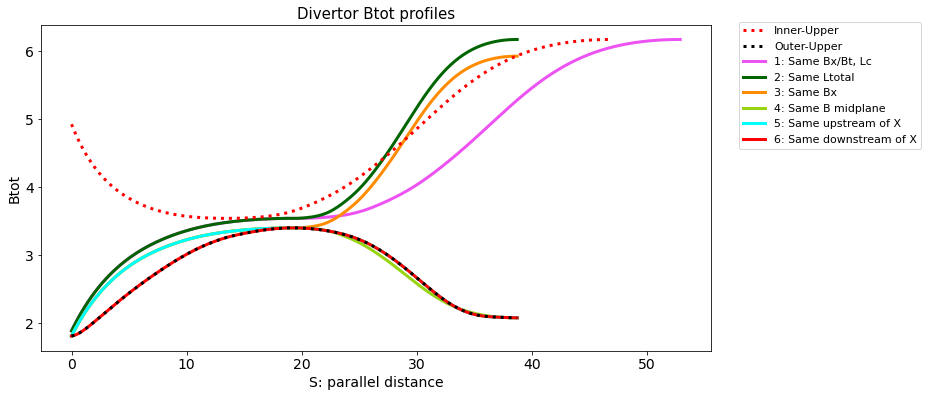

In [30]:
d_ou = data["ou"]
d_iu = data["iu"]
d_ius = data["iu"].copy()


BxBt_iu = d_iu["Btot"][d_iu["Xpoint"]] / d_iu["Btot"][0]
Lc_iu = d_iu["S"][d_iu["Xpoint"]]

BxBt_ou = d_ou["Btot"][d_ou["Xpoint"]] / d_ou["Btot"][0]
Lc_ou = d_ou["S"][d_ou["Xpoint"]]

list_BxBt = np.linspace(BxBt_iu, BxBt_ou, 5)
list_Lc = np.linspace(Lc_iu, Lc_ou, 5)

d_ius["Btot"] = scale_BxBt(d_ius["Btot"], d_ius["Xpoint"], BxBt=BxBt_ou)
d_ius["S"], d_ius["Spol"] = scale_Lc(d_ius["S"], d_ius["Spol"], d_ius["Xpoint"], Lc = Lc_ou)

data["iu_s"] = d_ius

# Scale total connection length
d_ius2 = copy.deepcopy(d_ius)
Lu_base  = d_ius["S"][-1] - d_ius["S"][d_ius["Xpoint"]]
Lu_target = d_ou["S"][-1] - d_ou["S"][d_ou["Xpoint"]]
d_ius2["S"][d_ius2["Xpoint"]:] *= Lu_target / Lu_base 
# d_ius2["Spol"][d_ius2["Xpoint"]:] *= Lu_target / Lu_base 
d_ius2["S"][d_ius2["Xpoint"]:] +=   d_ou["S"][-1] - d_ius2["S"][-1]
# d_ius2["Spol"][d_ius2["Xpoint"]:] +=  d_ou["Spol"][-1] - d_ius2["Spol"][-1]
data["iu_s2"] = d_ius2

# Match Bx
d_ius3 = copy.deepcopy(data["iu_s2"])
d_ius3["Btot"] *= d_ou["Btot"][d_ou["Xpoint"]] / d_ius3["Btot"][d_ius3["Xpoint"]]
data["iu_s3"] = d_ius3

# Match Bmp/Bx
d_ius4 = copy.deepcopy(data["iu_s3"])
Bmp_base = d_ius4["Btot"][-1]
Bmp_new = d_ou["Btot"][-1]
Bx_base = d_ius4["Btot"][d_ius4["Xpoint"]]

d_ius4["Btot"][d_ius4["Xpoint"]:] *= (Bx_base - Bmp_new) / (Bx_base - Bmp_base)
d_ius4["Btot"][d_ius4["Xpoint"]:] += d_ou["Btot"][-1] - d_ius4["Btot"][-1]

data["iu_s4"] = d_ius4

# Match upstream profile
d_ius5 = copy.deepcopy(data["iu_s4"])
d_ius5["Btot"] = np.concatenate([d_ius5["Btot"][:d_ius5["Xpoint"]], d_ou["Btot"][d_ou["Xpoint"]:]]) 
d_ius5["S"] = np.concatenate([d_ius5["S"][:d_ius5["Xpoint"]], d_ou["S"][d_ou["Xpoint"]:]]) 
data["iu_s5"] = d_ius5

# Match downstream profile
d_ius6 = copy.deepcopy(data["iu_s5"])

d_ius6["Btot"] = np.concatenate([d_ou["Btot"][:d_ou["Xpoint"]], d_ius6["Btot"][d_ius6["Xpoint"]:]]) 
d_ius6["S"] = np.concatenate([d_ou["S"][:d_ou["Xpoint"]], d_ius6["S"][d_ius6["Xpoint"]:]]) 
d_ius6["Xpoint"] = d_ou["Xpoint"]
data["iu_s6"] = d_ius6

cmap = plt.get_cmap("plasma")
colors = make_colors(len(list_BxBt), cmap)[::-1]
transparent = 0.2

side_labels = {"ou":"outer-upper", "iu":"inner-upper", "iu_s":"1: Same Bx/Bt, Lc", "iu_s2":"2: Same Ltotal", "iu_s3":"3: Same Bx", "iu_s4":"4: Same B midplane",
              "iu_s5":"5: Same upstream of X", "iu_s6":"6: Same downstream of X"}
styles = dict(); markers = dict(); colors = dict()
for i, x in enumerate(side_labels.keys()):
    styles[x]="solid" 
    markers[x] = "o"
    colors[x] = cc.colorwheel[int(255*i/len(side_labels))]
    
markers["iu_s3"] = "v"
styles["iu_s3"] = "dotted"
colors["iu_s5"] = "cyan"
colors["iu_s3"] = "darkorange"
colors["iu_s2"] = "darkgreen"
colors["iu_s6"] = "red"
alphas = [1] * (len(side_labels))
for i, x in enumerate(alphas):
    if i > 7:
        alphas[i]=0.1

for param in ["S"]:
    fig, ax = plt.subplots(figsize=(12,6))
    
    ax.plot(data["iu"][param], data["iu"]["Btot"],  linewidth = 3, linestyle = "dotted", label = "Inner-Upper", zorder = 10, color = "red")
    ax.plot(data["ou"][param], data["ou"]["Btot"],  linewidth = 3, linestyle = "dotted", label = "Outer-Upper", zorder = 10, color = "black")
    
    for i, side in enumerate(side_labels.keys()):
        if side not in ["iu", "ou"]:
            ax.plot(data[side][param], data[side]["Btot"], linewidth = 3, label = side_labels[side], zorder =1, color = colors[side], alpha = alphas[i])
    # ax.plot(data["iu_s"][param], data["iu_s"]["Btot"],  linewidth = 3, label = "s1: Same Bx/Bt, LC", zorder = 1, color = "blue", alpha = transparent)
    # ax.plot(data["iu_s2"][param], data["iu_s2"]["Btot"],  linewidth = 3, label = "s2: Same Ltotal", zorder = 1, color = "darkorange", alpha = transparent)
    # ax.plot(data["iu_s3"][param], data["iu_s3"]["Btot"],  linewidth = 3, label = "s3: Same Bx", zorder = 1, color = "purple", alpha = transparent)
    # ax.plot(data["iu_s4"][param], data["iu_s4"]["Btot"],  linewidth = 3, label = "s4: Same Bmp", zorder = 1, color = "limegreen", alpha = transparent)
    # ax.plot(data["iu_s5"][param], data["iu_s5"]["Btot"],  linewidth = 3, label = "s5: Same upstream", zorder = 1, color = "magenta")
    # ax.plot(data["iu_s6"][param], data["iu_s6"]["Btot"],  linewidth = 3, label = "s6: Same downstream", zorder = 1, color = "brown")
    
    ylims = ax.axes.get_ylim()
    # ax.vlines(0, ylims[0], ylims[1], color = "black", linestyle = "dashed", label = "Target", linewidth = 3)


    # ax.vlines(data["ou"]["S"][data["ou"]["Xpoint"]], ylims[0], ylims[1], linestyle = "solid", linewidth =3, color = "red")
    # ax.vlines(data["iu"]["S"][data["iu"]["Xpoint"]], ylims[0], ylims[1], linestyle = "dotted", linewidth =3, color = "green")
    # ax.vlines(data["iu_s"]["S"][data["iu_s"]["Xpoint"]], ylims[0], ylims[1], linestyle = "dotted", linewidth =3, color = "blue")

    ax.set_title("Divertor Btot profiles", fontsize = 15)
    fig.legend(bbox_to_anchor=(1.15,0.9),fontsize = 11)
    ax.set_xlabel("S: parallel distance"); 
    ax.set_ylabel("Btot")
    ax.grid(which="both")

store_colors = colors.copy()

# Run cases

In [44]:
# results = dict()

#set switches
radios_default = {
    "ionisation": False,  # in development
    "upstreamGrid": True, #if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants_default = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "qpllu0": 1e9, # heat flux density at the x point
    "nu" : 1e20, #upstream density
    "nu0" : 1e20,
    "cz0" : 0.02,
    "kappa0" : 2500,
    "mi": 3*10**(-27),
    "echarge": 1.60*10**(-19), 
    "Tt": 0.5, # requested virtual target temp. Aim for low (sub 1eV) Tt
    "Lfunc": LfuncKallenbachAr, #impurity cooling function
    "alpha": 1000, #flux limiting alpha. Only matters if fluxlim is true
}


# Progressive morphing impact

In [13]:
stepmorph_ne = dict()

for side in data.keys():
    print("Solving side", side)
    out = []
    i=0
    results = dict()
    for param in ["window", "threshold", "window_ratio"]:
        results[param] = []
    

    d = data[side].copy()

    constants = constants_default.copy()
    radios = radios_default.copy()
    indexRange = np.linspace(0, d["Xpoint"]-1, 15).astype(int)
    radios["upstreamGrid"] = True
    constants["XpointIndex"] = d["Xpoint"] # Index of Xpoint
    constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
    constants["cz0"] = 0.05
    out.append(LRBv21(constants,radios,d["S"],d["Spol"],indexRange, 
                                        Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 1, verbosity = 0,
                                        control_variable = "density"))
    out[i]["SpolPlot"] = [data[side]["Spol"][x] for x in indexRange]
    results["window"].append(out[i]["cvar"][-1] - out[i]["cvar"][0])
    results["window_ratio"].append(out[i]["cvar"][-1] / out[i]["cvar"][0])
    results["threshold"].append(out[i]["cvar"][0])
    results["indexRange"] = indexRange
    results["constants"] = constants
    results["radios"] = radios
    results["out"] = out
    
    # Take out any thresholds for a window ratio < 1
    for i, x in enumerate(results["threshold"]):
        if results["window_ratio"][i] < 1:
            results["threshold"][i] = np.nan
    try:
        results["rel_threshold"] = results["threshold"] / max([x for x in results["threshold"] if ~np.isnan(x)])
    except:
        pass

    stepmorph_ne[side] = results.copy()

Solving side iu
55
qradial: 2.141E+07
Solving...0...3...7...11...15...19...23...27...30...34...38...42...46...50...54...Complete in 16.2 seconds
Solving side ou
183
qradial: 6.133E+07
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...182...Complete in 13.1 seconds
Solving side iu_s
55
qradial: 2.141E+07
Solving...0...3...7...11...15...19...23...27...30...34...38...42...46...50...54...Complete in 16.1 seconds
Solving side iu_s2
55
qradial: 3.658E+07
Solving...0...3...7...11...15...19...23...27...30...34...38...42...46...50...54...Complete in 16.8 seconds
Solving side iu_s3
55
qradial: 3.658E+07
Solving...0...3...7...11...15...19...23...27...30...34...38...42...46...50...54...Complete in 16.8 seconds
Solving side iu_s4
55
qradial: 6.197E+07
Solving...0...3...7...11...15...19...23...27...30...34...38...42...46...50...54...Complete in 13.9 seconds
Solving side iu_s5
55
qradial: 6.133E+07
Solving...0...3...7...11...15...19...23...27...30...34...38...42...4

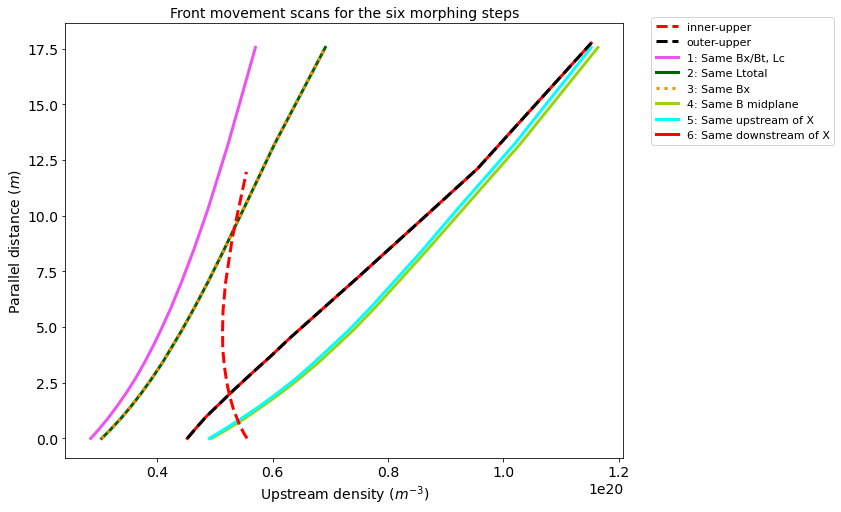

In [14]:
fig, ax = plt.subplots(figsize = (10,8))


side = "iu"
results = stepmorph_ne[side]
ax.plot(results["out"][0]["cvar"], results["out"][0]["Splot"], linewidth = 3, 
                marker = markers[side], markersize = 0, color = "red",
                linestyle = "dashed", label = side_labels[side], zorder = 10)

side = "ou"
results = stepmorph_ne[side]
ax.plot(results["out"][0]["cvar"], results["out"][0]["Splot"], linewidth = 3, 
                marker = markers[side], markersize = 0, color = "black",
                linestyle = "dashed", label = side_labels[side], zorder = 10)

for side in data.keys():
    if side not in ["iu", "ou"]:
        results = stepmorph_ne[side]

        ax.plot(results["out"][0]["cvar"], results["out"][0]["Splot"], linewidth = 3, 
                marker = markers[side], markersize = 0, color = colors[side],
                linestyle = styles[side], label = side_labels[side])
    
ax.set_xlabel("Upstream density ($m^{-3}$)")
ax.set_ylabel("Parallel distance ($m$)")
ax.set_title("Front movement scans for the six morphing steps")
fig.legend(bbox_to_anchor=(1.2,0.9),fontsize = 11)
ax.grid()

# Investigate profiles showing impact of flux expansion above X point

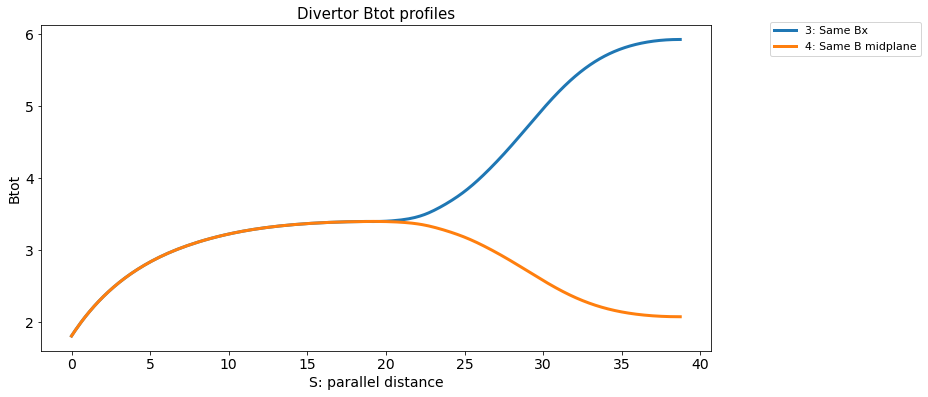

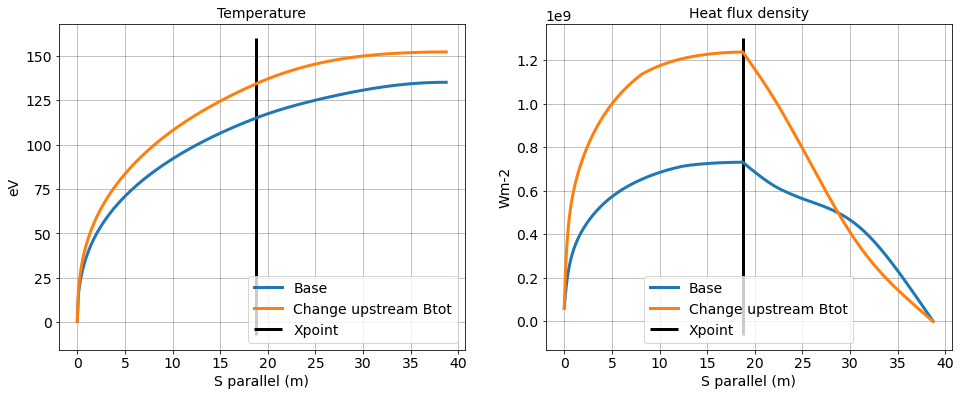

In [15]:

for param in ["S"]:
    fig, ax = plt.subplots(figsize=(12,6))
    # ax.plot(data["iu"][param], data["iu"]["Btot"],  linewidth = 3, linestyle = "dotted", label = "Inner-Upper", zorder = 10, color = "red")
    # ax.plot(data["ou"][param], data["ou"]["Btot"],  linewidth = 3, linestyle = "dotted", label = "Outer-Upper", zorder = 10, color = "black")
    for i, side in enumerate(side_labels.keys()):
        if side in ["iu_s3", "iu_s4"]:
            ax.plot(data[side][param], data[side]["Btot"], linewidth = 3, label = side_labels[side], zorder =1, alpha = alphas[i])
    ax.set_title("Divertor Btot profiles", fontsize = 15)
    fig.legend(bbox_to_anchor=(1.15,0.9),fontsize = 11)
    ax.set_xlabel("S: parallel distance"); 
    ax.set_ylabel("Btot")
    ax.grid(which="both")

fig, axes = plt.subplots(1,2, figsize=(16,6))
A = stepmorph_ne["iu_s3"]["out"][0]
B = stepmorph_ne["iu_s4"]["out"][0]

ax = axes[0]
ax.plot(A["Sprofiles"][0], A["Tprofiles"][0], label = "Base", linewidth = 3)
ax.plot(B["Sprofiles"][0], B["Tprofiles"][0], label = "Change upstream Btot", linewidth = 3)
ax.set_title("Temperature")
ax.set_ylabel("eV")

ax = axes[1]
ax.plot(A["Sprofiles"][0], A["Qprofiles"][0], label = "Base", linewidth = 3)
ax.plot(B["Sprofiles"][0], B["Qprofiles"][0], label = "Change upstream Btot", linewidth = 3)
ax.set_title("Heat flux density")
ax.set_ylabel("Wm-2")

for ax in axes:
    ylims = ax.get_ylim()
    ax.vlines(data["iu_s4"]["S"][data["iu_s4"]["Xpoint"]], ylims[0], ylims[1], color = "black", label = "Xpoint")
    ax.grid(color="black", alpha = 0.3)
    ax.set_xlabel("S parallel (m)")
    
    ax.legend()

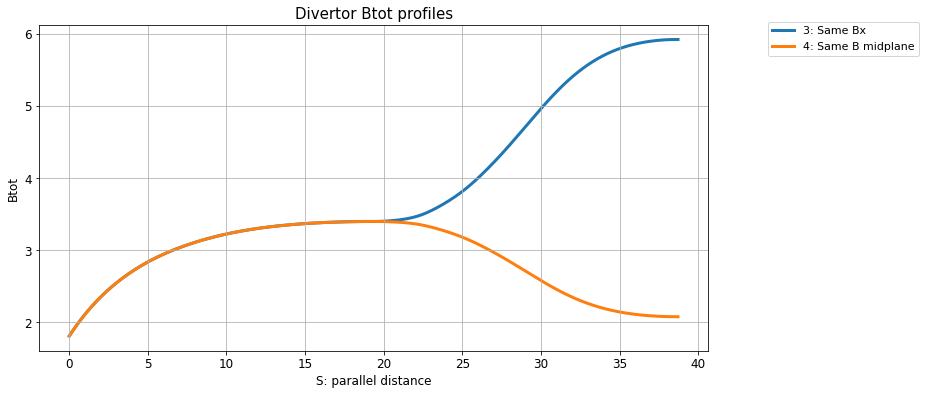

In [51]:
for param in ["S"]:
    fig, ax = plt.subplots(figsize=(12,6))
    # ax.plot(data["iu"][param], data["iu"]["Btot"],  linewidth = 3, linestyle = "dotted", label = "Inner-Upper", zorder = 10, color = "red")
    # ax.plot(data["ou"][param], data["ou"]["Btot"],  linewidth = 3, linestyle = "dotted", label = "Outer-Upper", zorder = 10, color = "black")
    for i, side in enumerate(side_labels.keys()):
        if side in ["iu_s3", "iu_s4"]:
            ax.plot(data[side][param], data[side]["Btot"], linewidth = 3, label = side_labels[side], zorder =1, alpha = alphas[i])
    ax.set_title("Divertor Btot profiles", fontsize = 15)
    fig.legend(bbox_to_anchor=(1.15,0.9),fontsize = 11)
    ax.set_xlabel("S: parallel distance"); 
    ax.set_ylabel("Btot")
    ax.grid(which="both")


## Check what q we got at the Xpoint

Text(0.5, 1.0, 'q at the Xpoint for different front locations')

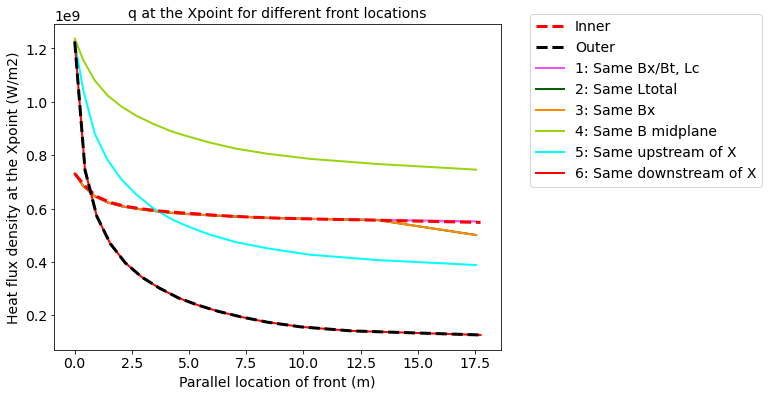

In [16]:
q_at_x = dict()

for i, side in enumerate(side_labels.keys()):
    
    o = stepmorph_ne[side]["out"][0]
    Xpoint = data[side]["Xpoint"]
    q_at_x[side] = []
    
    for profile in o["Qprofiles"]:
        q_at_x[side].append(profile[Xpoint])
    

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(o["Splot"], q_at_x["iu"], label = "Inner", color = "red", linestyle = "dashed", linewidth = 3, zorder = 5)
ax.plot(o["Splot"], q_at_x["ou"], label = "Outer", color = "black", linestyle = "dashed", linewidth = 3, zorder = 5)

for side in q_at_x:
    if side not in ["iu", "ou"]:
        o = stepmorph_ne[side]["out"][0]
        ax.plot(o["Splot"], q_at_x[side], label = side_labels[side], color = colors[side], linewidth = 2)


ax.grid()
ax.legend(bbox_to_anchor=(1.05,1.05))
ax.set_xlabel("Parallel location of front (m)")
ax.set_ylabel("Heat flux density at the Xpoint (W/m2)")
ax.set_title("q at the Xpoint for different front locations")
# q_at_x[side]

# Implement qradial fix

In [32]:
stepmorph_ne_fix = dict()

for side in data.keys():
    print("Solving side", side)
    out = []
    i=0
    results = dict()
    for param in ["window", "threshold", "window_ratio"]:
        results[param] = []
        
    d = data[side].copy()

    constants = constants_default.copy()
    radios = radios_default.copy()
    indexRange = np.linspace(0, d["Xpoint"]-1, 15).astype(int)
    radios["upstreamGrid"] = True
    constants["XpointIndex"] = d["Xpoint"] # Index of Xpoint
    constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
    constants["cz0"] = 0.05
    constants["Lfunc"] = LfuncN
    out.append(LRBv21(constants,radios,d["S"],d["Spol"],indexRange, 
                                        Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 1, verbosity = 0,
                                        control_variable = "density",
                                        qradial_fix = True, qradial_fix2 = False))
    
    out[i]["SpolPlot"] = [data[side]["Spol"][x] for x in indexRange]
    results["window"].append(out[i]["cvar"][-1] - out[i]["cvar"][0])
    results["window_ratio"].append(out[i]["cvar"][-1] / out[i]["cvar"][0])
    results["threshold"].append(out[i]["cvar"][0])
    results["indexRange"] = indexRange
    results["constants"] = constants
    results["radios"] = radios
    results["out"] = out
    
    # Take out any thresholds for a window ratio < 1
    for i, x in enumerate(results["threshold"]):
        if results["window_ratio"][i] < 1:
            results["threshold"][i] = np.nan
    try:
        results["rel_threshold"] = results["threshold"] / max([x for x in results["threshold"] if ~np.isnan(x)])
    except:
        pass

    stepmorph_ne_fix[side] = results.copy()

Solving side iu
Solving...0...3...7...11...15...19...23...27...30...34...38...42...46...50...54...Complete in 27.5 seconds
Solving side ou
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...182...Complete in 20.1 seconds
Solving side iu_s
Solving...0...3...7...11...15...19...23...27...30...34...38...42...46...50...54...Complete in 20.0 seconds
Solving side iu_s2
Solving...0...3...7...11...15...19...23...27...30...34...38...42...46...50...54...Complete in 18.4 seconds
Solving side iu_s3
Solving...0...3...7...11...15...19...23...27...30...34...38...42...46...50...54...Complete in 18.1 seconds
Solving side iu_s4
Solving...0...3...7...11...15...19...23...27...30...34...38...42...46...50...54...Complete in 15.4 seconds
Solving side iu_s5
Solving...0...3...7...11...15...19...23...27...30...34...38...42...46...50...54...Complete in 15.9 seconds
Solving side iu_s6
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...182...Comple

## Plot q at Xpoint again

Text(0.5, 1.0, 'q at the Xpoint for different front locations')

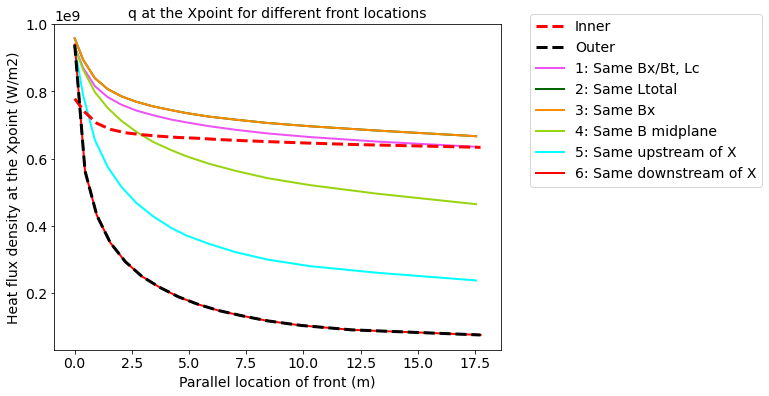

In [34]:
q_at_x = dict()

for i, side in enumerate(side_labels.keys()):
    
    o = stepmorph_ne_fix[side]["out"][0]
    Xpoint = data[side]["Xpoint"]
    q_at_x[side] = []
    
    for profile in o["Qprofiles"]:
        q_at_x[side].append(profile[Xpoint])
    

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(o["Splot"], q_at_x["iu"], label = "Inner", color = "red", linestyle = "dashed", linewidth = 3, zorder = 5)
ax.plot(o["Splot"], q_at_x["ou"], label = "Outer", color = "black", linestyle = "dashed", linewidth = 3, zorder = 5)

for side in q_at_x:
    if side not in ["iu", "ou"]:
        o = stepmorph_ne_fix[side]["out"][0]
        ax.plot(o["Splot"], q_at_x[side], label = side_labels[side], color = store_colors[side], linewidth = 2)


ax.grid()
ax.legend(bbox_to_anchor=(1.05,1.05))
ax.set_xlabel("Parallel location of front (m)")
ax.set_ylabel("Heat flux density at the Xpoint (W/m2)")
ax.set_title("q at the Xpoint for different front locations")
# q_at_x[side]

### Plot q profiles

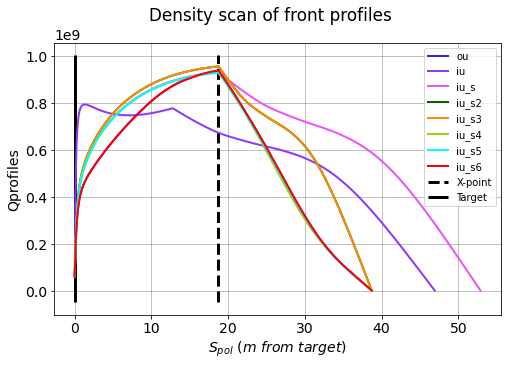

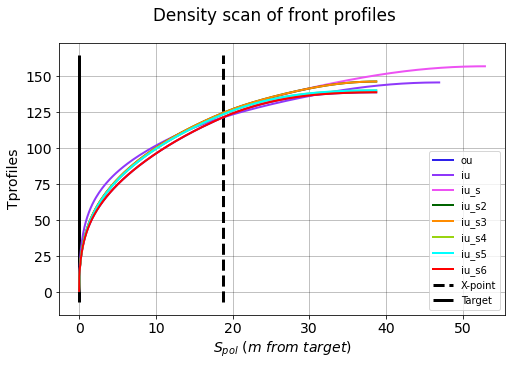

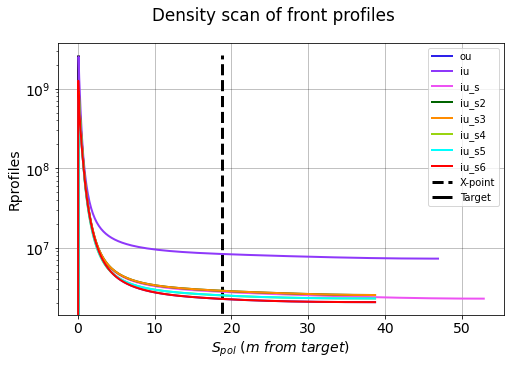

In [35]:
labels = {"cvar_trim":"$n_{u}\ (m^{-3})$", "crel_trim":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
labels = {"cvar":"$n_{u}\ (m^{-3})$", "crel":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
colors = mike_cmap(5)
store = lmscan
cvar = "density"


for param in ["Qprofiles", "Tprofiles", "Rprofiles"]:

    fig, ax = plt.subplots(figsize = (8,5))
    fig.suptitle("Density scan of front profiles")

    for i, side in enumerate(side_labels.keys()):
        d = data[side]
        o = stepmorph_ne_fix[side]["out"][0]
        point = 0
        ax.plot(o["Sprofiles"][point], o[param][point], linewidth = 2,  color = store_colors[side], label = side)

    ylim = ax.get_ylim()
    ax.vlines(d["S"][d["Xpoint"]], ylim[0], ylim[1], label = "X-point", color = "black", linestyle = "dashed")
    ax.vlines(0, ylim[0], ylim[1], label = "Target", color = "black", linestyle = "solid")

    if param == "Rprofiles":
        ax.set_yscale("log")

    ax.grid(color ="black", alpha = 0.3)
    ax.set_xlabel("$S_{pol}\ (m\ from\ target)$")
    ax.set_ylabel(param)
    ax.legend(fontsize = 10, loc = "best")
    ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0f}"))
        # ax.set_xlim(30,35)
        # ax.xaxis.set_minor_locator(MultipleLocator(0.1))


## Find threshold/window ratios

In [29]:
thresholds = []
windows = []

for i, side in enumerate(side_labels.keys()):
    
    o = stepmorph_ne_fix[side]["out"][0]
    Xpoint = data[side]["Xpoint"]
    windows.append(o["window_ratio"])
    thresholds.append(o["threshold"])

windows = np.array(windows)
thresholds = np.array(thresholds)

w_ratio = windows/windows[0]
t_ratio = 1/ (thresholds/thresholds[0])

for i, side in enumerate(side_labels.keys()):
    print(" || W ratio: {:.2f} || T ratio: {:.2f} || W/T: {:.2f} || {}".format(w_ratio[i], t_ratio[i], w_ratio[i]/t_ratio[i], side_labels[side]))
    

 || W ratio: 1.00 || T ratio: 1.00 || W/T: 1.00 || outer-upper
 || W ratio: 0.42 || T ratio: 0.48 || W/T: 0.87 || inner-upper
 || W ratio: 0.88 || T ratio: 0.98 || W/T: 0.90 || 1: Same Bx/Bt, Lc
 || W ratio: 1.00 || T ratio: 0.92 || W/T: 1.09 || 2: Same Ltotal
 || W ratio: 1.00 || T ratio: 0.92 || W/T: 1.09 || 3: Same Bx
 || W ratio: 0.93 || T ratio: 0.92 || W/T: 1.01 || 4: Same B midplane
 || W ratio: 0.95 || T ratio: 0.92 || W/T: 1.03 || 5: Same upstream of X
 || W ratio: 1.00 || T ratio: 1.00 || W/T: 1.00 || 6: Same downstream of X


# Scale upstream length

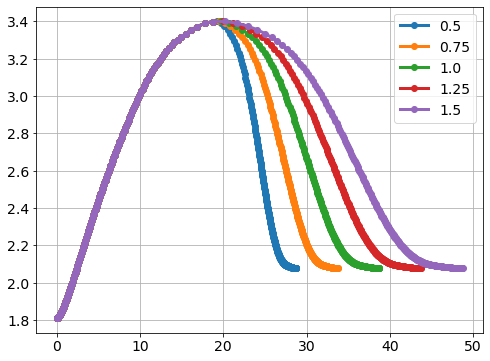

In [74]:
# d_lmscale[0] = copy.deepcopy(data["ou"])
d_lmscale = dict()
list_Lm_scales = np.array([0.5, 0.75, 1, 1.25, 1.50])
side = "ou"

fig, ax = plt.subplots()
for case in list_Lm_scales:
    d = copy.deepcopy(data["ou"])
    d["S"], d["Spol"] = scale_Lm(d["S"], d["Spol"], d["Xpoint"], scale_factor = case)
    d_lmscale[case] = d
    ax.plot(d["S"], d["Btot"], marker = "o", label = case)
    
ax.legend()




## Run

## NEW

In [49]:
list_cvars = ["density"]

# list_designs = ["SPR38_hiq"]


store = dict()

    
for cvar in list_cvars:
    store[cvar] = dict()
    print(f"Variable {cvar}...", end = "")

    for case in list_Lm_scales:
        print("Case {}...".format(case))

        d = d_lmscale[case].copy()
        constants = constants_default.copy()
        radios = radios_default.copy()
        constants["XpointIndex"] = d["Xpoint"] # Index of Xpoint   
        constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
        SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 15)
        indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange] 

        # if side == "iu":
        #     constants["qpllu0"] = 1e8*q_mult
        # elif side == "ou":
        #     constants["qpllu0"] = 1e9*q_mult

        store[cvar][case] = LRBv21(constants,radios,d["S"],d["Spol"], indexRange, 
                                            Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 0, qradial_fix2 = False,
                                            control_variable = cvar)

lmscan = copy.deepcopy(store)

Variable density...Case 0.5...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 18.0 seconds
Case 0.75...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 15.8 seconds
Case 1...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 18.2 seconds
Case 1.25...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 18.3 seconds
Case 1.5...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 16.6 seconds


## OLD

In [40]:
lmscan2 = dict()

for side in list_Lm_scales:
    print("Solving side", side)
    out = []
    i=0
    results = dict()
    for param in ["window", "threshold", "window_ratio"]:
        results[param] = []
        
    d = d_lmscale[side].copy()

    constants = constants_default.copy()
    radios = radios_default.copy()
    SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 15)
    indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange] 
    radios["upstreamGrid"] = True
    constants["XpointIndex"] = d["Xpoint"] # Index of Xpoint
    constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
    constants["cz0"] = 0.05
    constants["Lfunc"] = LfuncN
    results = (LRBv21(constants,radios,d["S"],d["Spol"],indexRange, 
                                        Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 1, verbosity = 0,
                                        control_variable = "density",
                                        qradial_fix = True, qradial_fix2 = False))
    
    results["SpolPlot"] = [d["Spol"][x] for x in indexRange]
    # results["window"] = results["cvar"][-1] - results["cvar"][0]
    # results["window_ratio"]= out[i]["cvar"][-1] / out[i]["cvar"][0]
    # results["threshold"] = out[i]["cvar"][0]
    results["indexRange"] = indexRange
    results["constants"] = constants
    results["radios"] = radios
    

    lmscan2[side] = results.copy()

Solving side 0.5
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...182...Complete in 10.0 seconds
Solving side 0.75
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...182...Complete in 9.8 seconds
Solving side 1
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...182...Complete in 10.8 seconds
Solving side 1.25
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...182...Complete in 11.4 seconds
Solving side 1.5
Solving...0...13...26...39...52...65...78...91...104...117...130...143...156...169...182...Complete in 9.7 seconds


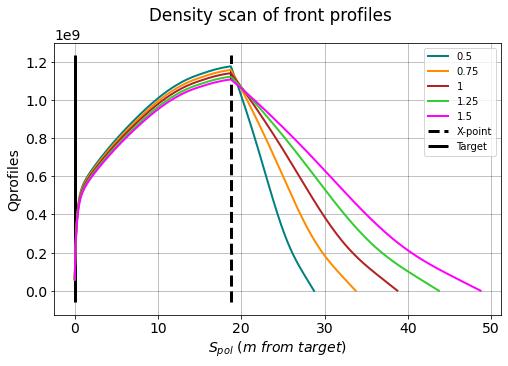

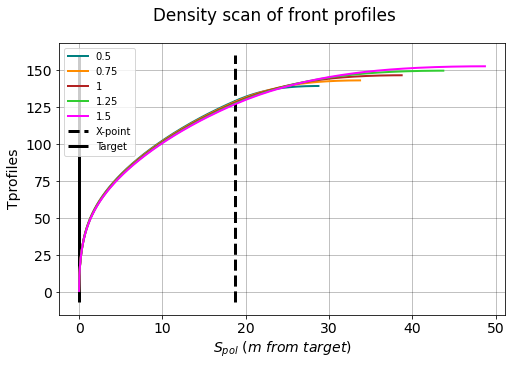

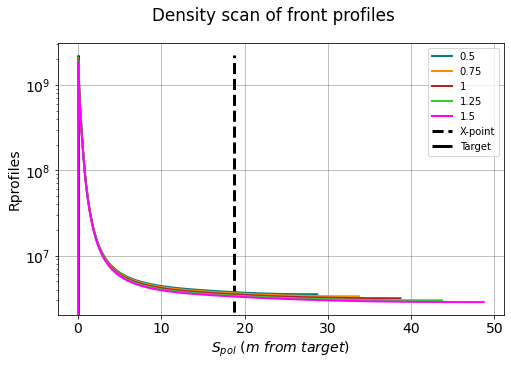

In [48]:
labels = {"cvar_trim":"$n_{u}\ (m^{-3})$", "crel_trim":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
labels = {"cvar":"$n_{u}\ (m^{-3})$", "crel":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
colors = mike_cmap(5)
store = lmscan
cvar = "density"


for param in ["Qprofiles", "Tprofiles", "Rprofiles"]:

    fig, ax = plt.subplots(figsize = (8,5))
    fig.suptitle("Density scan of front profiles")

    for i, case in enumerate(list_Lm_scales):
        d = d_lmscale[case]
        o = store[cvar][case]
        point = 0
        ax.plot(o["Sprofiles"][point], o[param][point], linewidth = 2,  color = colors[i], label = case)

    ylim = ax.get_ylim()
    ax.vlines(d["S"][d["Xpoint"]], ylim[0], ylim[1], label = "X-point", color = "black", linestyle = "dashed")
    ax.vlines(0, ylim[0], ylim[1], label = "Target", color = "black", linestyle = "solid")

    if param == "Rprofiles":
        ax.set_yscale("log")

    ax.grid(color ="black", alpha = 0.3)
    ax.set_xlabel("$S_{pol}\ (m\ from\ target)$")
    ax.set_ylabel(param)
    ax.legend(fontsize = 10, loc = "best")
    ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0f}"))
        # ax.set_xlim(30,35)
        # ax.xaxis.set_minor_locator(MultipleLocator(0.1))


### Profiles

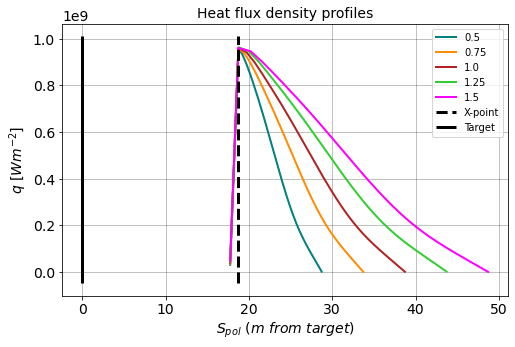

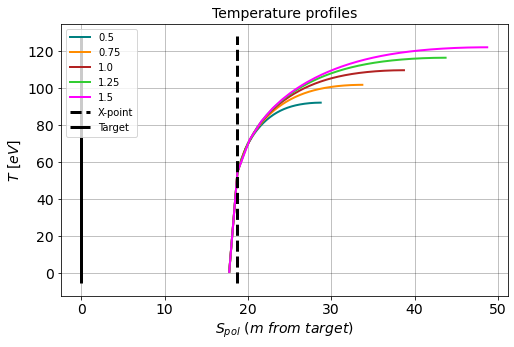

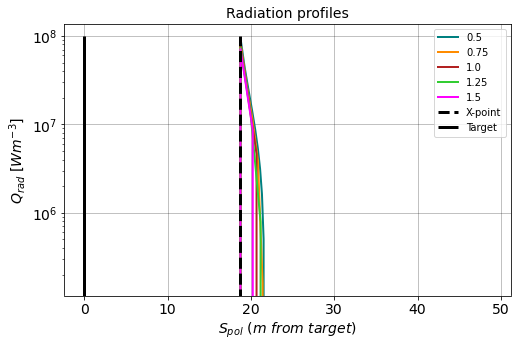

In [114]:
labels = {"cvar_trim":"$n_{u}\ (m^{-3})$", "crel_trim":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
labels = {"cvar":"$n_{u}\ (m^{-3})$", "crel":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
colors = mike_cmap(5)
store = lmscan2
cvar = "density"


for param in ["Qprofiles", "Tprofiles", "Rprofiles"]:

    fig, ax = plt.subplots(figsize = (8,5))
    ax.set_title(profile_names[param])

    for i, case in enumerate(list_Lm_scales):
        d = d_lmscale[case]
        o = store[case]
        point = -1
        ax.plot(o["Sprofiles"][point], o[param][point], linewidth = 2,  color = colors[i], label = case)

    ylim = ax.get_ylim()
    ax.vlines(d["S"][d["Xpoint"]], ylim[0], ylim[1], label = "X-point", color = "black", linestyle = "dashed", zorder = 10)
    ax.vlines(0, ylim[0], ylim[1], label = "Target", color = "black", linestyle = "solid")

    if param == "Rprofiles":
        ax.set_yscale("log")

    ax.grid(color ="black", alpha = 0.3)
    ax.set_xlabel("$S_{pol}\ (m\ from\ target)$")
    ax.set_ylabel(profile_labels[param])
    ax.legend(fontsize = 10, loc = "best")
    ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0f}"))
        # ax.set_xlim(30,35)
        # ax.xaxis.set_minor_locator(MultipleLocator(0.1))


### Front locations

No handles with labels found to put in legend.


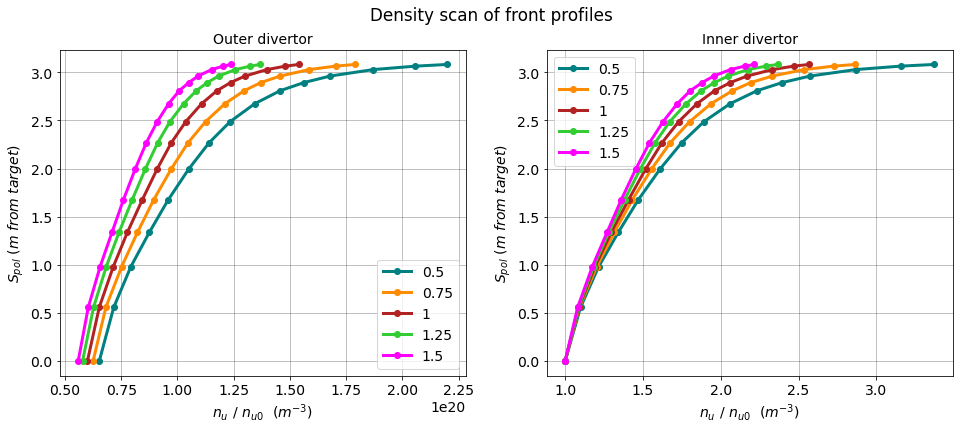

In [60]:
labels = {"cvar_trim":"$n_{u}\ (m^{-3})$", "crel_trim":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
labels = {"cvar":"$n_{u}\ (m^{-3})$", "crel":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}

store = lmscan
cvar = "density"
colors = mike_cmap(5)


fig, axes = plt.subplots(1,2, figsize = (16,6))

for k, basis in enumerate(["cvar", "crel"]):
    
    
    fig.suptitle("Density scan of front profiles")
    ax = axes[0]
    
    for i, case in enumerate(list_Lm_scales):

        o = store[cvar][case]

        axes[k].plot(o[basis], o["SpolPlot"],  marker = "o", label = case, markersize = 6, linewidth = 3, color = colors[i])

#     ylims = axes[1].get_ylim()
#     axes[1].set_ylim(0,ylims[1])

    for ax in axes:
        ax.grid(color ="black", alpha = 0.3)
        ax.set_xlabel(labels[basis])
        ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")
        ax.legend()
        
    axes[0].set_title("Outer divertor")
    axes[1].set_title("Inner divertor")
    


### Threshold/window

In [81]:
thresholds = []
windows = []

for i, case in enumerate(list_Lm_scales):
    
    o = lmscan[cvar][case]
    Xpoint = data[side]["Xpoint"]
    windows.append(o["window_ratio"])
    thresholds.append(o["threshold"])

windows = np.array(windows)
thresholds = np.array(thresholds)

w_ratio = windows/windows[2]
t_ratio = 1/ (thresholds/thresholds[2])

for i, case in enumerate(list_Lm_scales):
    print(" || W ratio: {:.2f} || T ratio: {:.2f} || W/T: {:.2f}".format(w_ratio[i], t_ratio[i], w_ratio[i]/t_ratio[i]))
    

 || W ratio: 1.31 || T ratio: 0.92 || W/T: 1.43
 || W ratio: 1.12 || T ratio: 0.96 || W/T: 1.16
 || W ratio: 1.00 || T ratio: 1.00 || W/T: 1.00
 || W ratio: 0.92 || T ratio: 1.04 || W/T: 0.89
 || W ratio: 0.86 || T ratio: 1.07 || W/T: 0.80


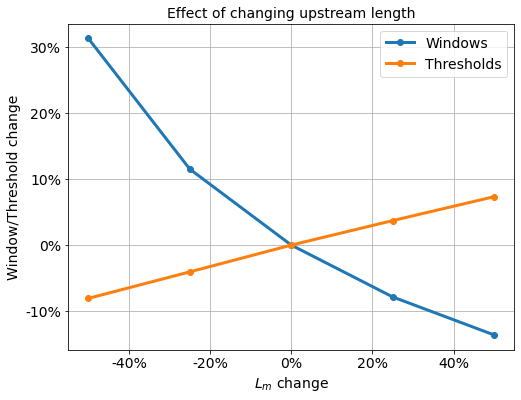

In [84]:
fig, ax = plt.subplots()
ax.plot(list_Lm_scales-1, w_ratio-1, label = "Windows", marker = "o")
ax.plot(list_Lm_scales-1, t_ratio-1, label = "Thresholds", marker = "o")
ax.set_xlabel("$L_m$ change")
ax.set_ylabel("Window/Threshold change")
ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.set_title("Effect of changing upstream length")
ax.legend()

# Scale downstream length

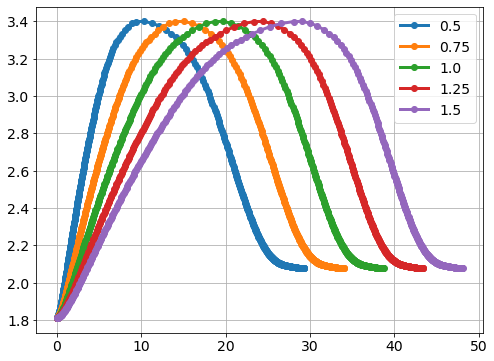

In [130]:
# d_lmscale[0] = copy.deepcopy(data["ou"])
d_lxscale = dict()
list_Lx_scales = np.array([0.5, 0.75, 1, 1.25, 1.50])
side = "ou"

fig, ax = plt.subplots()
for case in list_Lm_scales:
    d = copy.deepcopy(data["ou"])
    d["S"], d["Spol"] = scale_Lc(d["S"], d["Spol"], d["Xpoint"], scale_factor = case)
    d_lxscale[case] = d
    ax.plot(d["S"], d["Btot"], marker = "o", label = case)
    
ax.legend()




## Run

In [86]:
list_cvars = ["density"]

# list_designs = ["SPR38_hiq"]


store = dict()

    
for cvar in list_cvars:
    store[cvar] = dict()
    print(f"Variable {cvar}...", end = "")

    for case in list_Lm_scales:
        print("Case {}...".format(case))

        d = d_lxscale[case].copy()
        constants = constants_default.copy()
        radios = radios_default.copy()
        constants["XpointIndex"] = d["Xpoint"] # Index of Xpoint   
        constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
        SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 15)
        indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange] 

        # if side == "iu":
        #     constants["qpllu0"] = 1e8*q_mult
        # elif side == "ou":
        #     constants["qpllu0"] = 1e9*q_mult

        store[cvar][case] = LRBv21(constants,radios,d["S"],d["Spol"], indexRange, 
                                            Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 0, qradial_fix2 = False,
                                            control_variable = cvar)

lxscan = copy.deepcopy(store)

Variable density...Case 0.5...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 15.1 seconds
Case 0.75...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 16.1 seconds
Case 1.0...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 17.6 seconds
Case 1.25...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 17.5 seconds
Case 1.5...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 16.4 seconds


## PP

### Profiles

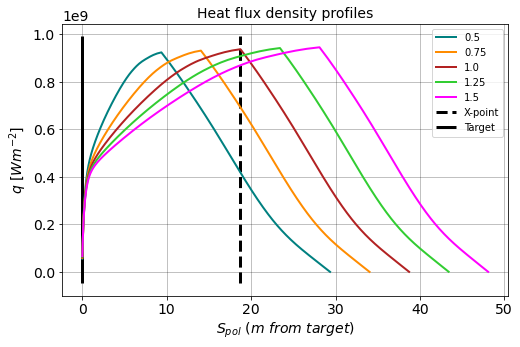

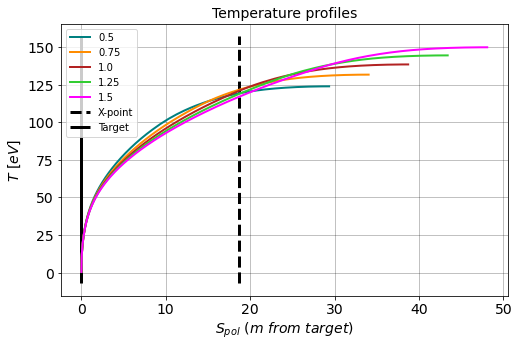

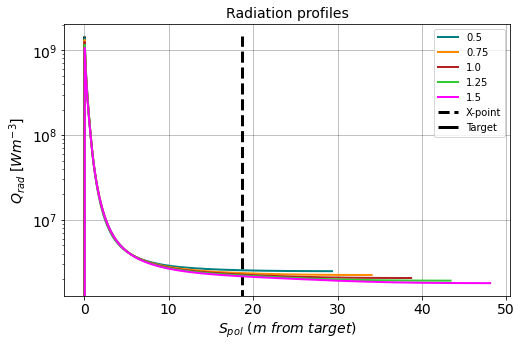

In [106]:
labels = {"cvar_trim":"$n_{u}\ (m^{-3})$", "crel_trim":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
labels = {"cvar":"$n_{u}\ (m^{-3})$", "crel":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
colors = mike_cmap(5)
store = lxscan
cvar = "density"
for param in ["Qprofiles", "Tprofiles", "Rprofiles"]:

    fig, ax = plt.subplots(figsize = (8,5))
    ax.set_title(profile_names[param])

    for i, case in enumerate(list_Lx_scales):
        d = d_lmscale[case]
        o = store[cvar][case]
        point = 0
        ax.plot(o["Sprofiles"][point], o[param][point], linewidth = 2,  color = colors[i], label = case)

    ylim = ax.get_ylim()
    ax.vlines(d["S"][d["Xpoint"]], ylim[0], ylim[1], label = "X-point", color = "black", linestyle = "dashed")
    ax.vlines(0, ylim[0], ylim[1], label = "Target", color = "black", linestyle = "solid")

    if param == "Rprofiles":
        ax.set_yscale("log")

    ax.grid(color ="black", alpha = 0.3)
    ax.set_xlabel("$S_{pol}\ (m\ from\ target)$")
    ax.set_ylabel(profile_labels[param])
    ax.legend(fontsize = 10, loc = "best")
    ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0f}"))


### Front locations

No handles with labels found to put in legend.


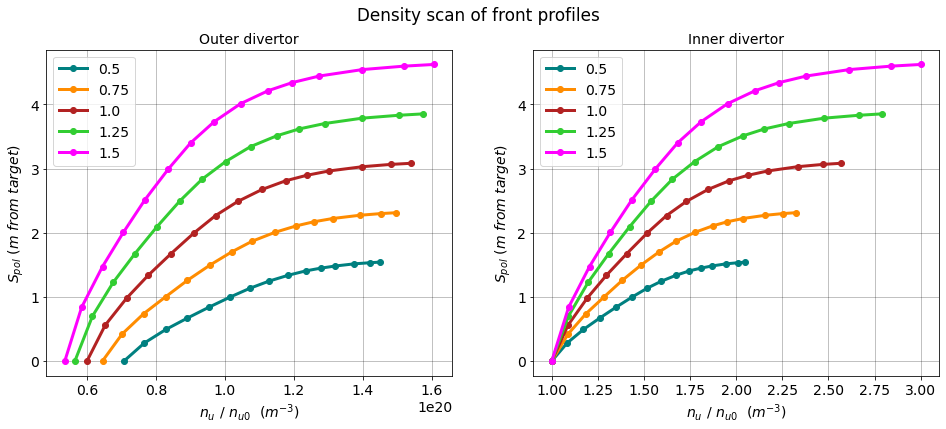

In [87]:
labels = {"cvar_trim":"$n_{u}\ (m^{-3})$", "crel_trim":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
labels = {"cvar":"$n_{u}\ (m^{-3})$", "crel":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}

store = lxscan
cvar = "density"
colors = mike_cmap(5)
fig, axes = plt.subplots(1,2, figsize = (16,6))
for k, basis in enumerate(["cvar", "crel"]):
    fig.suptitle("Density scan of front profiles")
    ax = axes[0] 
    for i, case in enumerate(list_Lm_scales):
        o = store[cvar][case]
        axes[k].plot(o[basis], o["SpolPlot"],  marker = "o", label = case, markersize = 6, linewidth = 3, color = colors[i])
    for ax in axes:
        ax.grid(color ="black", alpha = 0.3)
        ax.set_xlabel(labels[basis])
        ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")
        ax.legend()       
    axes[0].set_title("Outer divertor")
    axes[1].set_title("Inner divertor")

### Threshold/window

In [91]:
thresholds = []
windows = []

for i, case in enumerate(list_Lm_scales):
    
    o = lxscan[cvar][case]
    Xpoint = data[side]["Xpoint"]
    windows.append(o["window_ratio"])
    thresholds.append(o["threshold"])

windows = np.array(windows)
thresholds = np.array(thresholds)

w_ratio = windows/windows[2]
t_ratio = 1/ (thresholds/thresholds[2])

for i, case in enumerate(list_Lm_scales):
    print(" || W ratio: {:.2f} || T ratio: {:.2f} || W/T: {:.2f}".format(w_ratio[i], t_ratio[i], w_ratio[i]/t_ratio[i]))
    

 || W ratio: 0.80 || T ratio: 0.85 || W/T: 0.94
 || W ratio: 0.90 || T ratio: 0.93 || W/T: 0.97
 || W ratio: 1.00 || T ratio: 1.00 || W/T: 1.00
 || W ratio: 1.09 || T ratio: 1.06 || W/T: 1.02
 || W ratio: 1.17 || T ratio: 1.12 || W/T: 1.04


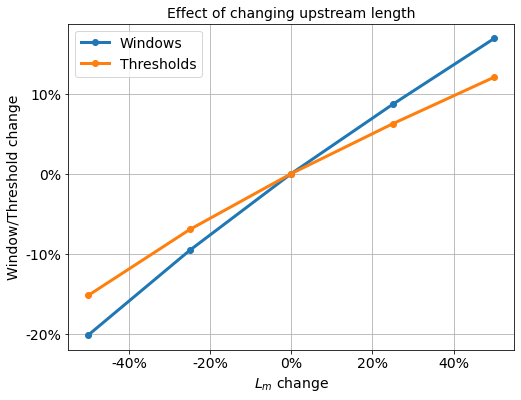

In [92]:
fig, ax = plt.subplots()
ax.plot(list_Lx_scales-1, w_ratio-1, label = "Windows", marker = "o")
ax.plot(list_Lx_scales-1, t_ratio-1, label = "Thresholds", marker = "o")
ax.set_xlabel("$L_m$ change")
ax.set_ylabel("Window/Threshold change")
ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.set_title("Effect of changing downstream length")
ax.legend()

# Scale Bx/Bt

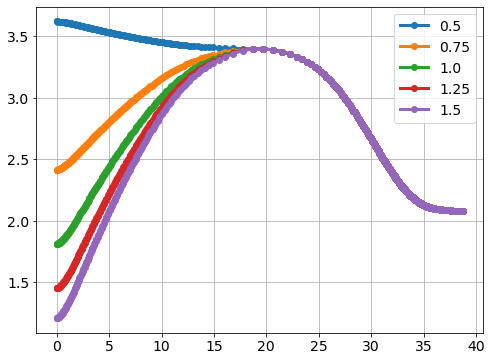

In [95]:
# d_lmscale[0] = copy.deepcopy(data["ou"])
d_BxBtscale = dict()
list_BxBt_scales = np.array([0.5, 0.75, 1, 1.25, 1.50])
side = "ou"

fig, ax = plt.subplots()
for case in list_BxBt_scales:
    d = copy.deepcopy(data["ou"])
    d["Btot"]= scale_BxBt(d["Btot"], d["Xpoint"], scale_factor = case)
    d_BxBtscale[case] = d
    ax.plot(d["S"], d["Btot"], marker = "o", label = case)
    
ax.legend()




## Run

In [96]:
list_cvars = ["density"]
store = dict()
for cvar in list_cvars:
    store[cvar] = dict()
    print(f"Variable {cvar}...", end = "")

    for case in list_BxBt_scales:
        print("Case {}...".format(case))

        d = d_BxBtscale[case].copy()
        constants = constants_default.copy()
        radios = radios_default.copy()
        constants["XpointIndex"] = d["Xpoint"] # Index of Xpoint   
        constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
        SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 15)
        indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange] 

        # if side == "iu":
        #     constants["qpllu0"] = 1e8*q_mult
        # elif side == "ou":
        #     constants["qpllu0"] = 1e9*q_mult

        store[cvar][case] = LRBv21(constants,radios,d["S"],d["Spol"], indexRange, 
                                            Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 0, qradial_fix2 = False,
                                            control_variable = cvar)

bxbtscan = copy.deepcopy(store)

Variable density...Case 0.5...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 16.7 seconds
Case 0.75...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 15.9 seconds
Case 1.0...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 17.6 seconds
Case 1.25...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 16.7 seconds
Case 1.5...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 16.4 seconds


## PP

### Profiles

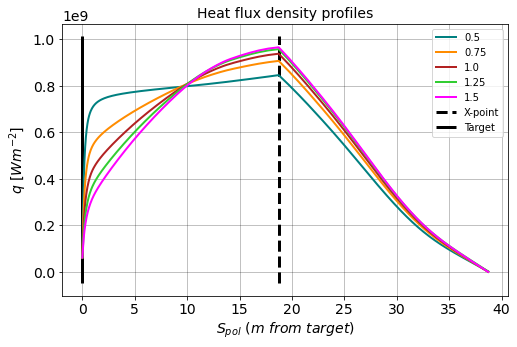

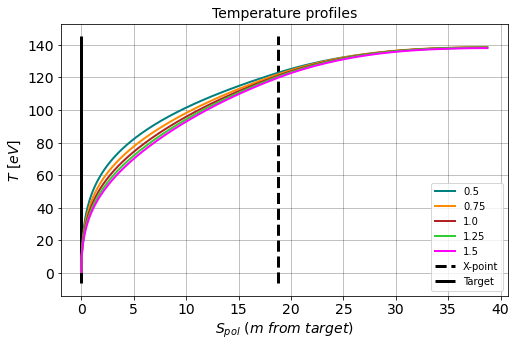

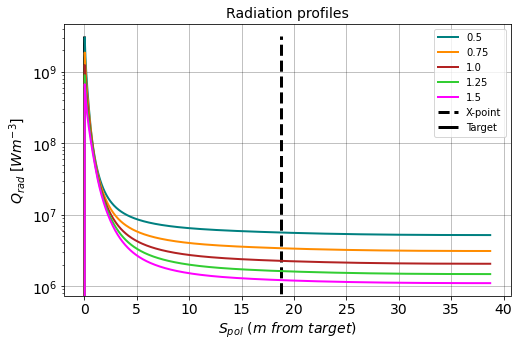

In [105]:
labels = {"cvar_trim":"$n_{u}\ (m^{-3})$", "crel_trim":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
labels = {"cvar":"$n_{u}\ (m^{-3})$", "crel":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
colors = mike_cmap(5)
store = bxbtscan
cvar = "density"
for param in ["Qprofiles", "Tprofiles", "Rprofiles"]:

    fig, ax = plt.subplots(figsize = (8,5))
    ax.set_title(profile_names[param])

    for i, case in enumerate(list_BxBt_scales):
        d = d_BxBtscale[case]
        o = store[cvar][case]
        point = 0
        ax.plot(o["Sprofiles"][point], o[param][point], linewidth = 2,  color = colors[i], label = case)

    ylim = ax.get_ylim()
    ax.vlines(d["S"][d["Xpoint"]], ylim[0], ylim[1], label = "X-point", color = "black", linestyle = "dashed")
    ax.vlines(0, ylim[0], ylim[1], label = "Target", color = "black", linestyle = "solid")

    if param == "Rprofiles":
        ax.set_yscale("log")

    ax.grid(color ="black", alpha = 0.3)
    ax.set_xlabel("$S_{pol}\ (m\ from\ target)$")
    ax.set_ylabel(profile_labels[param])
    ax.legend(fontsize = 10, loc = "best")
    ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0f}"))


### Front locations

No handles with labels found to put in legend.


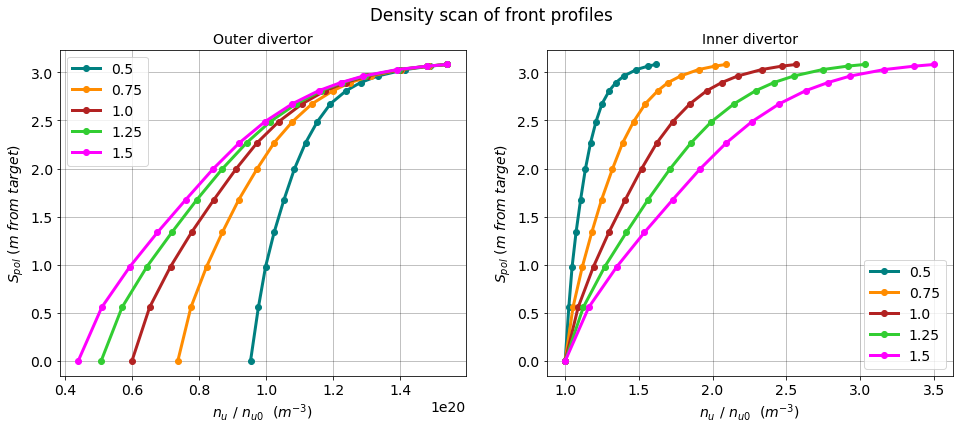

In [108]:
labels = {"cvar_trim":"$n_{u}\ (m^{-3})$", "crel_trim":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
labels = {"cvar":"$n_{u}\ (m^{-3})$", "crel":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}

store = bxbtscan
cvar = "density"
colors = mike_cmap(5)
fig, axes = plt.subplots(1,2, figsize = (16,6))
for k, basis in enumerate(["cvar", "crel"]):
    fig.suptitle("Density scan of front profiles")
    ax = axes[0] 
    for i, case in enumerate(list_BxBt_scales):
        o = store[cvar][case]
        axes[k].plot(o[basis], o["SpolPlot"],  marker = "o", label = case, markersize = 6, linewidth = 3, color = colors[i])
    for ax in axes:
        ax.grid(color ="black", alpha = 0.3)
        ax.set_xlabel(labels[basis])
        ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")
        ax.legend()       
    axes[0].set_title("Outer divertor")
    axes[1].set_title("Inner divertor")

### Threshold/window

In [109]:
thresholds = []
windows = []

for i, case in enumerate(list_BxBt_scales):
    
    o = bxbtscan[cvar][case]
    Xpoint = data[side]["Xpoint"]
    windows.append(o["window_ratio"])
    thresholds.append(o["threshold"])

windows = np.array(windows)
thresholds = np.array(thresholds)

w_ratio = windows/windows[2]
t_ratio = 1/ (thresholds/thresholds[2])

for i, case in enumerate(list_BxBt_scales):
    print(" || W ratio: {:.2f} || T ratio: {:.2f} || W/T: {:.2f}".format(w_ratio[i], t_ratio[i], w_ratio[i]/t_ratio[i]))
    

 || W ratio: 0.63 || T ratio: 0.63 || W/T: 1.00
 || W ratio: 0.81 || T ratio: 0.81 || W/T: 1.00
 || W ratio: 1.00 || T ratio: 1.00 || W/T: 1.00
 || W ratio: 1.18 || T ratio: 1.18 || W/T: 1.00
 || W ratio: 1.36 || T ratio: 1.36 || W/T: 1.00


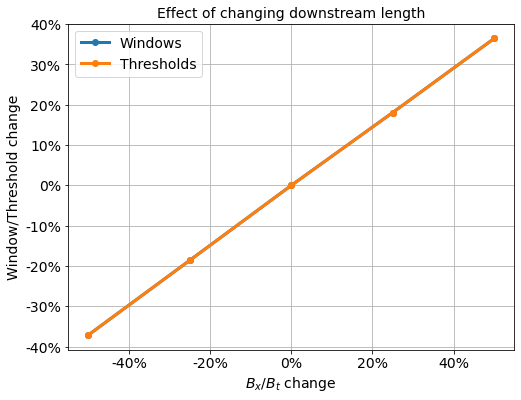

In [110]:
fig, ax = plt.subplots()
ax.plot(list_BxBt_scales-1, w_ratio-1, label = "Windows", marker = "o")
ax.plot(list_BxBt_scales-1, t_ratio-1, label = "Thresholds", marker = "o")
ax.set_xlabel("$B_{x}/B_{t}$ change")
ax.set_ylabel("Window/Threshold change")
ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.set_title("Effect of changing downstream length")
ax.legend()

# PREP STUDIES

In [470]:
studies = dict()

# ALL RUN

## Lm

In [471]:
list_cvars = ["density"]

# list_designs = ["SPR38_hiq"]


store = dict()

    
for cvar in list_cvars:
    store[cvar] = dict()
    print(f"Variable {cvar}...", end = "")

    for case in list_Lm_scales:
        print("Case {}...".format(case))

        d = d_lmscale[case].copy()
        constants = constants_default.copy()
        radios = radios_default.copy()
        constants["XpointIndex"] = d["Xpoint"] # Index of Xpoint   
        constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
        SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 15)
        indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange] 
        store[cvar][case] = LRBv21(constants,radios,d["S"],d["Spol"], indexRange, 
                                            Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 0, qradial_fix2 = False,
                                            control_variable = cvar)

lmscan = copy.deepcopy(store)

Variable density...Case 0.5...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 17.2 seconds
Case 0.75...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 16.8 seconds
Case 1.0...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 18.2 seconds
Case 1.25...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 18.7 seconds
Case 1.5...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 19.0 seconds


## Lx

In [472]:
list_cvars = ["density"]

# list_designs = ["SPR38_hiq"]


store = dict()

    
for cvar in list_cvars:
    store[cvar] = dict()
    print(f"Variable {cvar}...", end = "")

    for case in list_Lm_scales:
        print("Case {}...".format(case))

        d = d_lxscale[case].copy()
        constants = constants_default.copy()
        radios = radios_default.copy()
        constants["XpointIndex"] = d["Xpoint"] # Index of Xpoint   
        constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
        SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 15)
        indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange] 
        store[cvar][case] = LRBv21(constants,radios,d["S"],d["Spol"], indexRange, 
                                            Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 0, qradial_fix2 = False,
                                            control_variable = cvar)

lxscan = copy.deepcopy(store)

Variable density...Case 0.5...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 16.9 seconds
Case 0.75...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 16.6 seconds
Case 1.0...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 18.8 seconds
Case 1.25...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 18.8 seconds
Case 1.5...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 17.3 seconds


## BxBt

In [473]:
list_cvars = ["density"]
store = dict()
for cvar in list_cvars:
    store[cvar] = dict()
    print(f"Variable {cvar}...", end = "")

    for case in list_BxBt_scales:
        print("Case {}...".format(case))

        d = d_BxBtscale[case].copy()
        constants = constants_default.copy()
        radios = radios_default.copy()
        constants["XpointIndex"] = d["Xpoint"] # Index of Xpoint   
        constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
        SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 15)
        indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange] 
        store[cvar][case] = LRBv21(constants,radios,d["S"],d["Spol"], indexRange, 
                                            Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 0, qradial_fix2 = False,
                                            control_variable = cvar)

bxbtscan = copy.deepcopy(store)

Variable density...Case 0.5...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 18.8 seconds
Case 0.75...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 19.5 seconds
Case 1.0...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 18.1 seconds
Case 1.25...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 17.1 seconds
Case 1.5...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 16.9 seconds


# ALL PP

## Prepare data

In [474]:
scales = [list_Lx_scales, list_Lm_scales, list_BxBt_scales]
stores = [lxscan, lmscan, bxbtscan]
datas = [d_lxscale, d_lmscale, d_BxBtscale]
names = ["$L_x$ scan", "$L_m$ scan", "$B_X/B_t$ scan"]
colors = mike_cmap(6)
Bavg_scales = [None]*3
Ltot_scales = [None]*3

for g in range(3):

    Bavgs = []
    Ltots = []
    for i, case in enumerate(scales[g]):
        d = datas[g][case]
        Bavgs.append(np.mean(d["Btot"][:d["Xpoint"]]))
        Ltots.append(d["S"][-1])

    Bavg_scales[g] = np.array(Bavgs) / Bavgs[2]
    Ltot_scales[g] = np.array(Ltots) / Ltots[2]

studies["density"] = copy.deepcopy(stores)

In [481]:
stores = studies["density"]
cvar = "density"

## Geometry

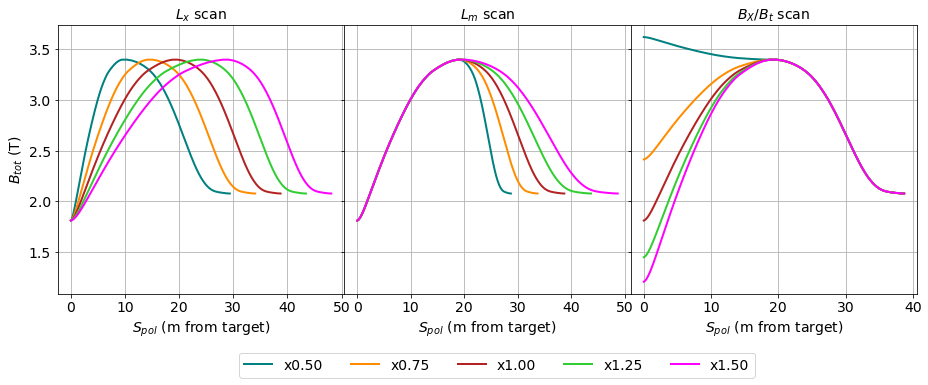

In [460]:
# d_lmscale[0] = copy.deepcopy(data["ou"])

fig, axes = plt.subplots(1, 3, figsize=(14*1.1,4.5*1.1), sharey = True)
fig.subplots_adjust(wspace=0)
scale = scales[0]
for g in range(3):

    ax = axes[g]
   
    store = stores[g]
    for i, case in enumerate(scales[g]):
        d = datas[g][case]
        if g == 0:
            ax.plot(d["S"], d["Btot"], label = "x{:.2f}".format(case), color = colors[i], linewidth = 2)
        else: 
            ax.plot(d["S"], d["Btot"], color = colors[i], linewidth = 2)
    ax.set_title(names[g])
    ax.set_xlabel("$S_{pol}$ (m from target)")
axes[0].set_ylabel("$B_{tot}$ (T)")
fig.legend(ncol = 6, bbox_to_anchor =(0.76,-0.02))




## Profiles

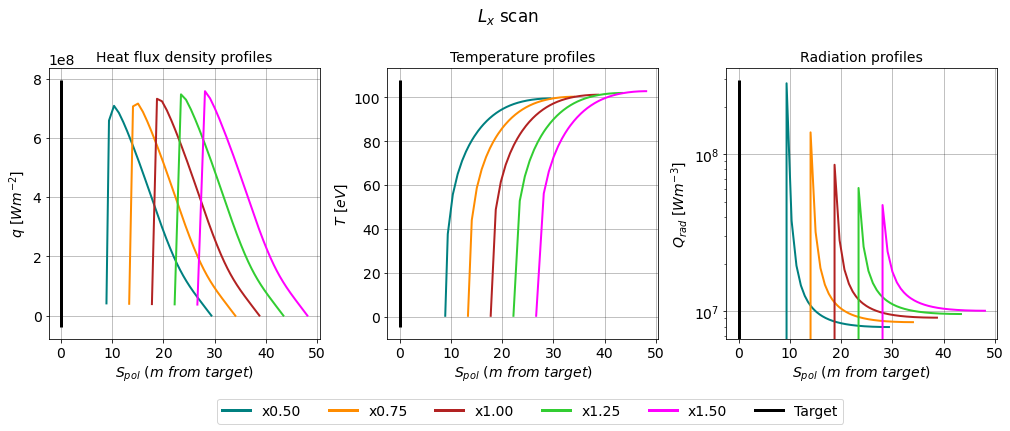

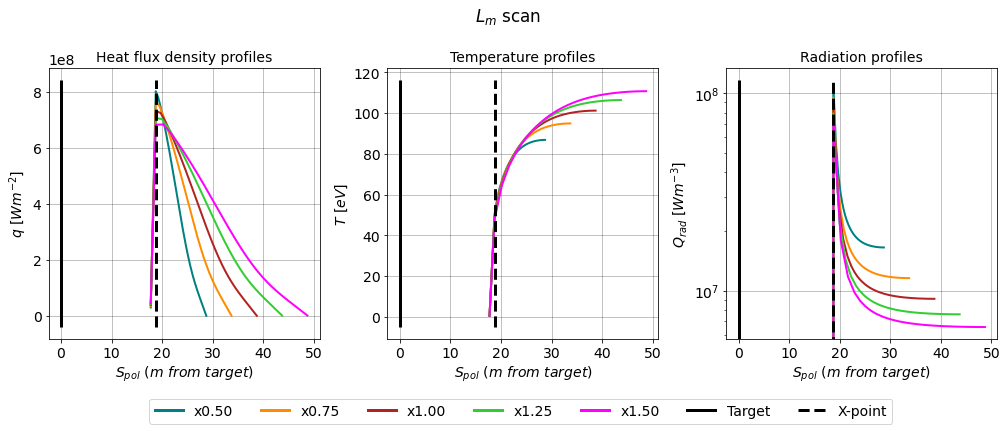

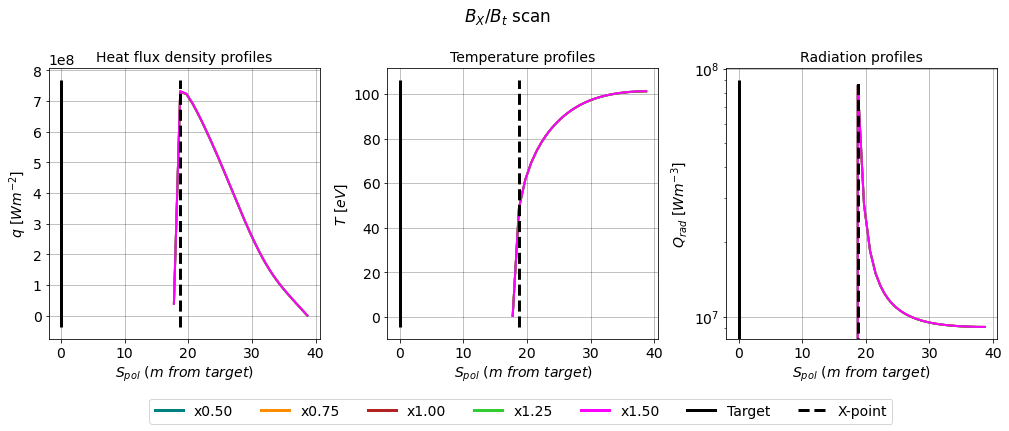

In [466]:
labels = {"cvar_trim":"$n_{u}\ (m^{-3})$", "crel_trim":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
labels = {"cvar":"$n_{u}\ (m^{-3})$", "crel":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
colors = mike_cmap(5)
cvar = "density"

for g in range(3):

    fig, axes = plt.subplots(1,3,figsize = (17,5))
    fig.suptitle(names[g], y = 1.05)
    fig.subplots_adjust(wspace=0.25)
    for k, param in enumerate(["Qprofiles", "Tprofiles", "Rprofiles"]):

        # fig.suptitle("Density scan of front profiles")
        ax = axes[k]
        ax.set_title(profile_names[param])

        for i, case in enumerate(scales[g]):
            d = datas[g][case]
            o = stores[g][cvar][case]
            point = -1
            if g == 0:
                ax.plot(o["Sprofiles"][point], o[param][point], linewidth = 2,  color = colors[i], label = "x{:.2f}".format(case))
            else:
                ax.plot(o["Sprofiles"][point], o[param][point], linewidth = 2,  color = colors[i])

        ylim = ax.get_ylim()
        if g != 0:
            ax.vlines(d["S"][d["Xpoint"]], ylim[0], ylim[1], color = "black", linestyle = "dashed", zorder = 100)
        
        ax.vlines(0, ylim[0], ylim[1], color = "black", linestyle = "solid", zorder = 100)

        if param == "Rprofiles":
            ax.set_yscale("log")

        ax.grid(color ="black", alpha = 0.3)
        ax.set_xlabel("$S_{pol}\ (m\ from\ target)$")
        ax.set_ylabel(profile_labels[param])
        ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0f}"))
        
    legend_elements = []
    
    for i, case in enumerate(scales[g]):
        legend_elements.append(mpl.lines.Line2D([0], [0], color=colors[i], lw=3, label = "x{:.2f}".format(case)))
    
    legend_elements.append(mpl.lines.Line2D([0], [0], color="black", linestyle = "solid", lw=3, label='Target'))
    
    if g != 0:
        legend_elements.append(mpl.lines.Line2D([0], [0], color="black", linestyle = "dashed", lw=3, label='X-point'))

    if g != 0:
        fig.legend(handles = legend_elements, ncol = 7, bbox_to_anchor =(0.82,-0.02))
    else:
        fig.legend(handles = legend_elements, ncol = 7, bbox_to_anchor =(0.78,-0.02))


In [462]:
stores[2]["density"][0.5]["constants"]

{'gamma_sheath': 7,
 'qpllu0': 1000000000.0,
 'nu': 1e+20,
 'nu0': 1e+20,
 'cz0': 0.02,
 'kappa0': 2500,
 'mi': 3e-27,
 'echarge': 1.6000000000000002e-19,
 'Tt': 0.5,
 'Lfunc': <function AnalyticCoolingCurves.LfuncKallenbachAr(T)>,
 'alpha': 1000,
 'XpointIndex': 183,
 'B': <scipy.interpolate.interpolate.interp1d at 0x1cb9573e860>}

## Front locations

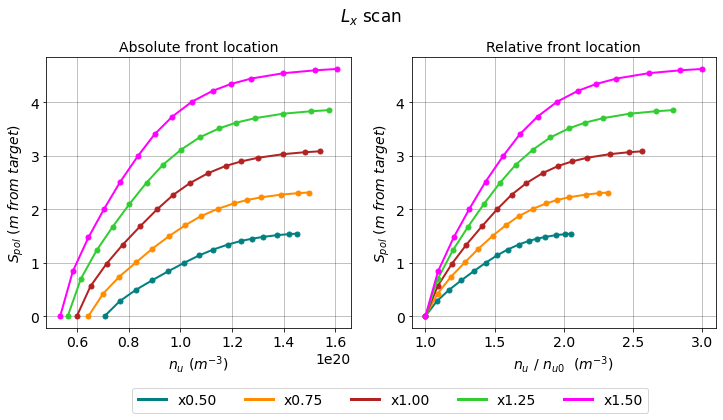

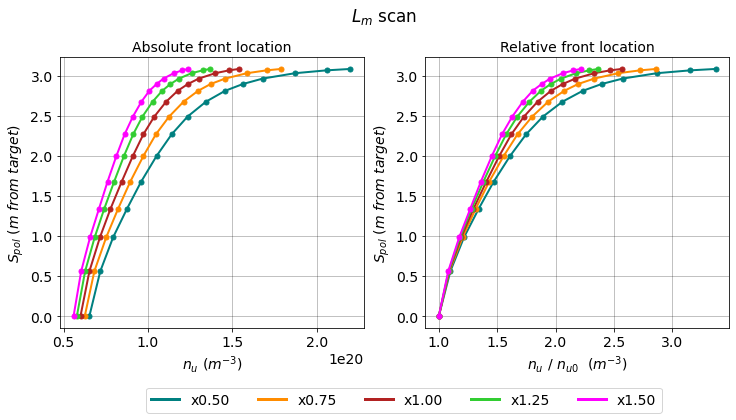

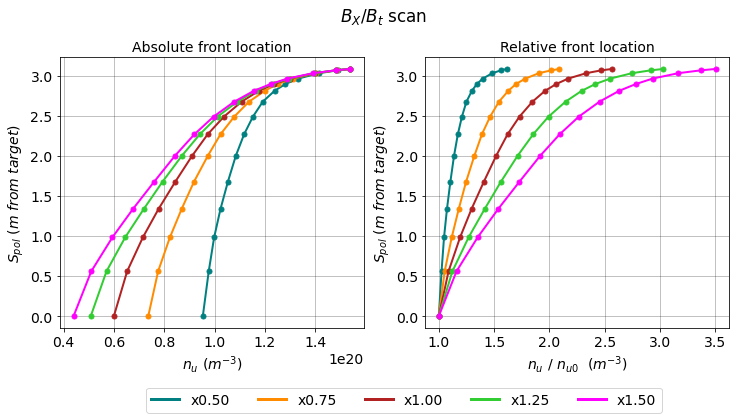

In [463]:
labels = {"cvar_trim":"$n_{u}\ (m^{-3})$", "crel_trim":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
labels = {"cvar":"$n_{u}\ (m^{-3})$", "crel":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
cvar = "density"

g = 0
for g in range(3):
    
    store = stores[g]
    colors = mike_cmap(5)
    fig, axes = plt.subplots(1,2, figsize = (12,5))
    for k, basis in enumerate(["cvar", "crel"]):
        fig.suptitle(names[g], y = 1.02)
        ax = axes[0] 
        for i, case in enumerate(scales[g]):
            o = store[cvar][case]
            axes[k].plot(o[basis], o["SpolPlot"],  marker = "o", markersize = 5, linewidth = 2, color = colors[i])
            axes[k].set_xlabel(labels[basis])
        for ax in axes:
            ax.grid(color ="black", alpha = 0.3)

            ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")      
        axes[0].set_title("Absolute front location")
        axes[1].set_title("Relative front location")


    legend_elements = [] 
    for i, case in enumerate(scales[g]):
        legend_elements.append(mpl.lines.Line2D([0], [0], color=colors[i], lw=3, label = "x{:.2f}".format(case)))

    fig.legend(handles = legend_elements, ncol = 5, bbox_to_anchor =(0.83,-0.02))

## Threshold/window

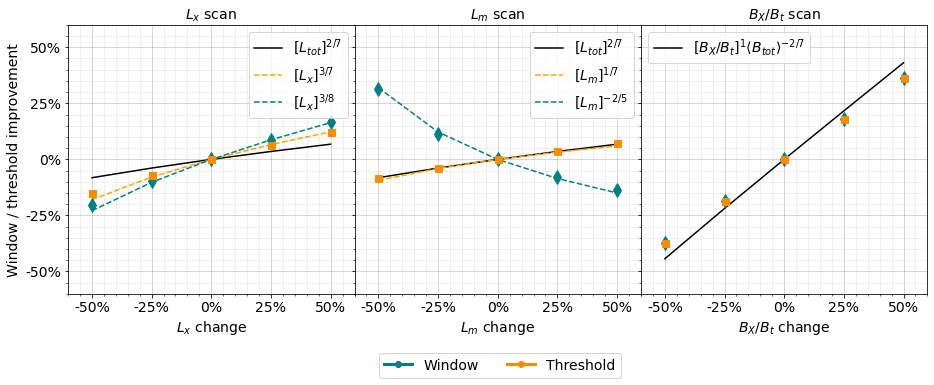

In [509]:
g = 0

thresholds = dict()
windows = dict()
w_ratio = dict()
t_ratio = dict()

for g in range(3):
    
    thresholds[g] = []
    windows[g] = []

    for i, case in enumerate(scales[g]):
        o = stores[g][cvar][case]
        Xpoint = datas[g][case]["Xpoint"]
        windows[g].append(o["window_ratio"])
        thresholds[g].append(o["threshold"])

    windows[g] = np.array(windows[g])
    thresholds[g] = np.array(thresholds[g])

    w_ratio[g] = windows[g]/windows[g][2]
    t_ratio[g] = 1/ (thresholds[g]/thresholds[g][2])

# for i, case in enumerate(scales[g]):
    # print(" || W ratio: {:.2f} || T ratio: {:.2f} || W/T: {:.2f}".format(w_ratio[g][i], t_ratio[g][i], w_ratio[g][i]/t_ratio[g][i]))

s = 1.1
fig, axes = plt.subplots(1, 3, figsize=(14*s,4.5*s), sharey = True)
fig.subplots_adjust(wspace=0)
for g in range(3):
    ax = axes[g]
    ax.set_title(names[g])
    ax.plot(scales[g]-1, w_ratio[g]-1, marker = "d", linestyle = "solid", color = colors[0], markersize = 10, linewidth = 0)
    ax.plot(scales[g]-1, t_ratio[g]-1, marker = "s", linestyle = "dashed", color = colors[1], markersize = 7, linewidth = 0)
    ax.set_xlabel("{} change".format(names[g].replace(" scan","")))
    
    ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
    ax.xaxis.set_major_locator(MultipleLocator(0.25))
    ax.yaxis.set_major_locator(MultipleLocator(0.25))
    ax.xaxis.set_minor_locator(MultipleLocator(0.05))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.grid(which="major", color = "black", alpha = 0.2)
    ax.grid(which="minor", color = "black", alpha = 0.075)
    ax.set_ylim(-0.60,0.60)
    ax.set_xlim(-0.60, 0.60)
    
zorder_scalings = 0
linewidth_scalings = 1.5
axes[0].plot(list_Lx_scales-1, Ltot_scales[1]**(2/7)-1, color = "black", linestyle = "solid", linewidth = linewidth_scalings, zorder = zorder_scalings,
            label = "$[L_{tot}]^{2/7}$")
axes[0].plot(list_Lx_scales-1, list_Lx_scales**(2/7)-1, color = "orange", linestyle = "dashed", linewidth = linewidth_scalings, zorder = zorder_scalings,
            label = "$[L_{x}]^{3/7}$")
axes[0].plot(list_Lx_scales-1,list_Lx_scales**(3/8)-1, color = "teal", linestyle = "dashed", linewidth = linewidth_scalings, zorder = zorder_scalings,
            label = "$[L_{x}]^{3/8}$")


axes[1].plot(list_Lm_scales-1, Ltot_scales[1]**(2/7)-1, color = "black", linestyle = "solid", linewidth = linewidth_scalings, zorder = zorder_scalings,
            label = "$[L_{tot}]^{2/7}$")
# axes[1].plot(list_Lm_scales-1, Ltot_scales[1]**(3/7)-1, color = "black", linestyle = "dashed", linewidth = linewidth_scalings, zorder = zorder_scalings,
#             label = "$[L_{tot}]^{3/7}$")

axes[1].plot(list_Lm_scales-1, list_Lm_scales**(1/7)-1, color = "orange", linestyle = "dashed", linewidth = linewidth_scalings, zorder = zorder_scalings,
            label = "$[L_{m}]^{1/7}$")
axes[1].plot(list_Lm_scales-1, list_Lm_scales**(-2/5)-1, color = "teal", linestyle = "dashed", linewidth = linewidth_scalings, zorder = zorder_scalings,
            label = "$[L_{m}]^{-2/5}$")

axes[2].plot(list_Lm_scales-1, list_BxBt_scales*(Bavg_scales[2]**(2/7))-1, color = "black", linestyle = "solid", linewidth = linewidth_scalings, zorder = zorder_scalings,
            label = r"$[B_X/B_t]^{1} {\langle}B_{tot}{\rangle}^{-2/7}$")

for ax in axes:
    ax.legend()
axes[0].set_ylabel("Window / threshold improvement")
legend_elements = [
    mpl.lines.Line2D([0], [0], color=colors[0], lw=3, marker = "o", label = "Window"),
    mpl.lines.Line2D([0], [0], color=colors[1], lw=3, marker = "o", label = "Threshold")]

fig.legend(handles = legend_elements, ncol = 5, bbox_to_anchor =(0.63,-0.02))

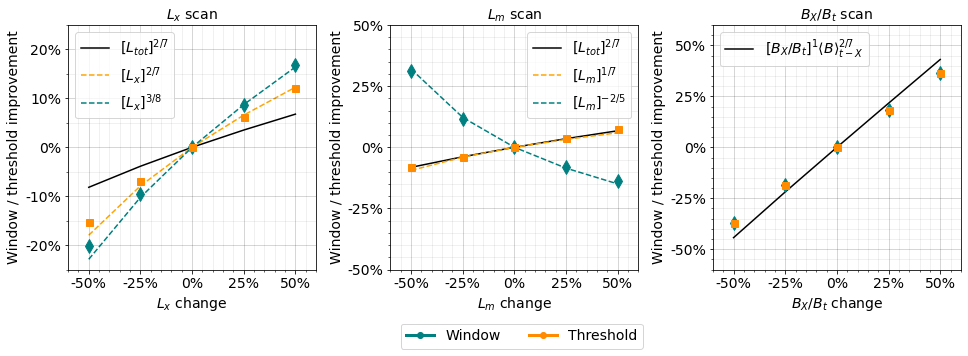

In [515]:
g = 0

thresholds = dict()
windows = dict()
w_ratio = dict()
t_ratio = dict()

for g in range(3):
    
    thresholds[g] = []
    windows[g] = []

    for i, case in enumerate(scales[g]):
        o = stores[g][cvar][case]
        Xpoint = datas[g][case]["Xpoint"]
        windows[g].append(o["window_ratio"])
        thresholds[g].append(o["threshold"])

    windows[g] = np.array(windows[g])
    thresholds[g] = np.array(thresholds[g])

    w_ratio[g] = windows[g]/windows[g][2]
    t_ratio[g] = 1/ (thresholds[g]/thresholds[g][2])

# for i, case in enumerate(scales[g]):
    # print(" || W ratio: {:.2f} || T ratio: {:.2f} || W/T: {:.2f}".format(w_ratio[g][i], t_ratio[g][i], w_ratio[g][i]/t_ratio[g][i]))
    
fig, axes = plt.subplots(1, 3, figsize=(16,4.5), sharey = False)
fig.subplots_adjust(wspace=.3)
for g in range(3):
    ax = axes[g]
    ax.set_title(names[g])
    ax.plot(scales[g]-1, w_ratio[g]-1, marker = "d", linestyle = "solid", color = colors[0], markersize = 10, linewidth = 0)
    ax.plot(scales[g]-1, t_ratio[g]-1, marker = "s", linestyle = "dashed", color = colors[1], markersize = 7, linewidth = 0)
    ax.set_xlabel("{} change".format(names[g].replace(" scan","")))
    
    ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
    ax.xaxis.set_major_locator(MultipleLocator(0.25))
    ax.yaxis.set_major_locator(MultipleLocator(0.25))
    ax.xaxis.set_minor_locator(MultipleLocator(0.05))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.grid(which="major", color = "black", alpha = 0.2)
    ax.grid(which="minor", color = "black", alpha = 0.075)
    ax.set_ylim(-0.60,0.60)
    ax.set_xlim(-0.60, 0.60)
    
axes[0].set_ylim(-0.25, 0.25)
axes[1].set_ylim(-0.50, 0.50)
axes[0].yaxis.set_major_locator(MultipleLocator(0.1))
    
zorder_scalings = 0
linewidth_scalings = 1.5
scale = 3/7
axes[0].plot(list_Lx_scales-1, Ltot_scales[1]**(2/7)-1, color = "black", linestyle = "solid", linewidth = linewidth_scalings, zorder = zorder_scalings,
            label = "$[L_{tot}]^{2/7}$")
axes[0].plot(list_Lx_scales-1, list_Lx_scales**(2/7)-1, color = "orange", linestyle = "dashed", linewidth = linewidth_scalings, zorder = zorder_scalings,
            label = "$[L_{x}]^{2/7}$")
axes[0].plot(list_Lx_scales-1,list_Lx_scales**(3/8)-1, color = "teal", linestyle = "dashed", linewidth = linewidth_scalings, zorder = zorder_scalings,
            label = "$[L_{x}]^{3/8}$")


axes[1].plot(list_Lm_scales-1, Ltot_scales[1]**(2/7)-1, color = "black", linestyle = "solid", linewidth = linewidth_scalings, zorder = zorder_scalings,
            label = "$[L_{tot}]^{2/7}$")
# axes[1].plot(list_Lm_scales-1, Ltot_scales[1]**(3/7)-1, color = "black", linestyle = "dashed", linewidth = linewidth_scalings, zorder = zorder_scalings,
#             label = "$[L_{tot}]^{3/7}$")

axes[1].plot(list_Lm_scales-1, list_Lm_scales**(1/7)-1, color = "orange", linestyle = "dashed", linewidth = linewidth_scalings, zorder = zorder_scalings,
            label = "$[L_{m}]^{1/7}$")
axes[1].plot(list_Lm_scales-1, list_Lm_scales**(-2/5)-1, color = "teal", linestyle = "dashed", linewidth = linewidth_scalings, zorder = zorder_scalings,
            label = "$[L_{m}]^{-2/5}$")

axes[2].plot(list_Lm_scales-1, list_BxBt_scales*(Bavg_scales[2]**(2/7))-1, color = "black", linestyle = "solid", linewidth = linewidth_scalings, zorder = zorder_scalings,
            label = r"$[B_X/B_t]^{1} {\langle}B{\rangle}^{2/7}_{t-X}$")



for ax in axes:
    ax.legend()
    ax.set_ylabel("Window / threshold improvement")
legend_elements = [
    mpl.lines.Line2D([0], [0], color=colors[0], lw=3, marker = "o", label = "Window"),
    mpl.lines.Line2D([0], [0], color=colors[1], lw=3, marker = "o", label = "Threshold")]

fig.legend(handles = legend_elements, ncol = 5, bbox_to_anchor =(0.63,-0.02))

In [512]:
list_BxBt_scales

array([0.5 , 0.75, 1.  , 1.25, 1.5 ])

In [511]:
Bavg_scales

[array([1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1.]),
 array([1.45689495, 1.15229832, 1.        , 0.90862101, 0.84770168])]

# RUN WITH N

## Lm

In [390]:
list_cvars = ["density"]

# list_designs = ["SPR38_hiq"]


store = dict()

    
for cvar in list_cvars:
    store[cvar] = dict()
    print(f"Variable {cvar}...", end = "")

    for case in list_Lm_scales:
        print("Case {}...".format(case))

        d = d_lmscale[case].copy()
        constants = constants_default.copy()
        radios = radios_default.copy()
        constants["XpointIndex"] = d["Xpoint"] # Index of Xpoint   
        constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
        SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 15)
        indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange] 
        constants["Lfunc"] = LfuncN

        store[cvar][case] = LRBv21(constants,radios,d["S"],d["Spol"], indexRange, 
                                            Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 0, qradial_fix2 = False,
                                            control_variable = cvar)

lmscan = copy.deepcopy(store)

Variable density...Case 0.5...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...

C:\Users\Mike\OneDrive\Project\DLS\DLS-model-main\LRBv21.py:62: RuntimeWarning: invalid value encountered in double_scalars
  dtds = qoverB*fieldValue/(kappa0*T**(5/2))
C:\Apps\Anaconda3\envs\py38\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
181...******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******


C:\Users\Mike\OneDrive\Project\DLS\DLS-model-main\LRBv21.py:371: RuntimeWarning: invalid value encountered in double_scalars
  error0 = (Tu-Tucalc)/Tu


******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration fact

C:\Users\Mike\OneDrive\Project\DLS\DLS-model-main\LRBv21.py:411: RuntimeWarning: invalid value encountered in double_scalars
  Qrad.append(((cvar**2*Tu**2)/Tf**2)*cz0*Lfunc(Tf))


******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration fact

## Lx

In [391]:
list_cvars = ["density"]

# list_designs = ["SPR38_hiq"]


store = dict()

    
for cvar in list_cvars:
    store[cvar] = dict()
    print(f"Variable {cvar}...", end = "")

    for case in list_Lm_scales:
        print("Case {}...".format(case))

        d = d_lxscale[case].copy()
        constants = constants_default.copy()
        radios = radios_default.copy()
        constants["XpointIndex"] = d["Xpoint"] # Index of Xpoint   
        constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
        SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 15)
        indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange] 
        constants["Lfunc"] = LfuncN

        store[cvar][case] = LRBv21(constants,radios,d["S"],d["Spol"], indexRange, 
                                            Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 0, qradial_fix2 = False,
                                            control_variable = cvar)

lxscan = copy.deepcopy(store)

Variable density...Case 0.5...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 13.0 seconds
Case 0.75...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 11.1 seconds
Case 1.0...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 11.9 seconds
Case 1.25...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 11.3 seconds
Case 1.5...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 11.5 seconds


## BxBt

In [392]:
list_cvars = ["density"]
store = dict()
for cvar in list_cvars:
    store[cvar] = dict()
    print(f"Variable {cvar}...", end = "")

    for case in list_BxBt_scales:
        print("Case {}...".format(case))

        d = d_BxBtscale[case].copy()
        constants = constants_default.copy()
        radios = radios_default.copy()
        constants["XpointIndex"] = d["Xpoint"] # Index of Xpoint   
        constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
        SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 15)
        indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange] 
        constants["Lfunc"] = LfuncN
    
        store[cvar][case] = LRBv21(constants,radios,d["S"],d["Spol"], indexRange, 
                                            Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 0, qradial_fix2 = False,
                                            control_variable = cvar)

bxbtscan = copy.deepcopy(store)

Variable density...Case 0.5...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 11.9 seconds
Case 0.75...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 11.1 seconds
Case 1.0...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 11.7 seconds
Case 1.25...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 11.8 seconds
Case 1.5...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 12.8 seconds


# ALL PP

## Prepare data

In [393]:
scales = [list_Lx_scales, list_Lm_scales, list_BxBt_scales]
stores = [lxscan, lmscan, bxbtscan]
datas = [d_lxscale, d_lmscale, d_BxBtscale]
names = ["$L_x$ scan", "$L_m$ scan", "$B_X/B_t$ scan"]
colors = mike_cmap(6)
Bavg_scales = [None]*3
Ltot_scales = [None]*3

for g in range(3):

    Bavgs = []
    Ltots = []
    for i, case in enumerate(scales[g]):
        d = datas[g][case]
        Bavgs.append(np.mean(d["Btot"][:d["Xpoint"]]))
        Ltots.append(d["S"][-1])

    Bavg_scales[g] = np.array(Bavgs) / Bavgs[2]
    Ltot_scales[g] = np.array(Ltots) / Ltots[2]

studies["N"] = copy.deepcopy(stores)

In [ ]:
stores = studies["N"]

## Geometry

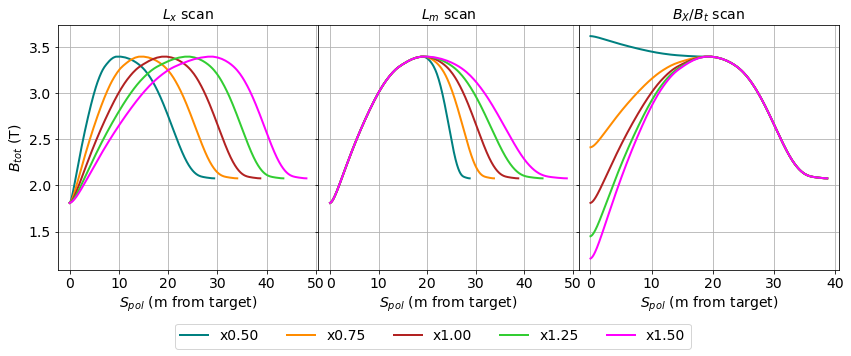

In [394]:
# d_lmscale[0] = copy.deepcopy(data["ou"])

fig, axes = plt.subplots(1, 3, figsize=(14,4.5), sharey = True)
fig.subplots_adjust(wspace=0)
scale = scales[0]
for g in range(3):

    ax = axes[g]
   
    store = stores[g]
    for i, case in enumerate(scales[g]):
        d = datas[g][case]
        if g == 0:
            ax.plot(d["S"], d["Btot"], label = "x{:.2f}".format(case), color = colors[i], linewidth = 2)
        else: 
            ax.plot(d["S"], d["Btot"], color = colors[i], linewidth = 2)
    ax.set_title(names[g])
    ax.set_xlabel("$S_{pol}$ (m from target)")
axes[0].set_ylabel("$B_{tot}$ (T)")
fig.legend(ncol = 6, bbox_to_anchor =(0.76,-0.02))




## Profiles

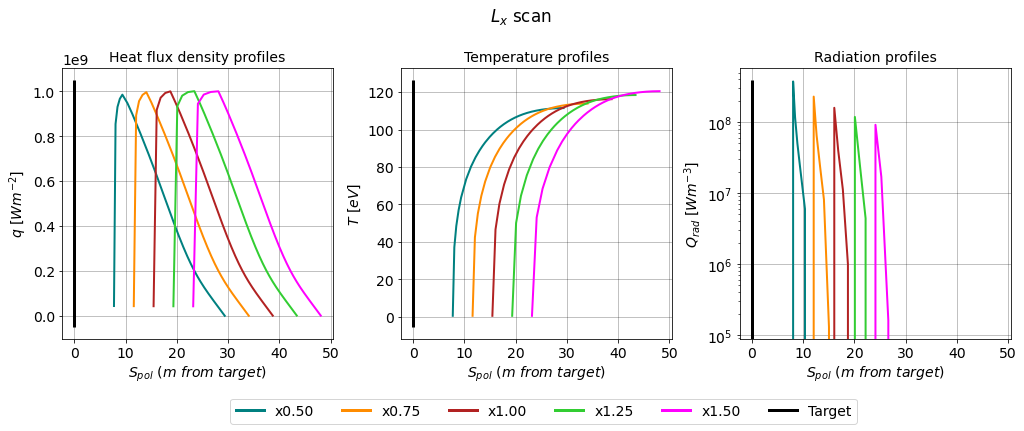

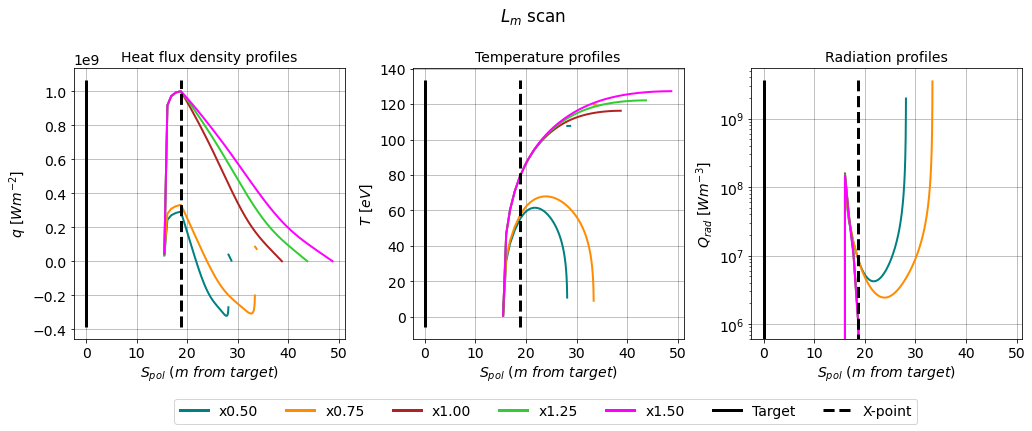

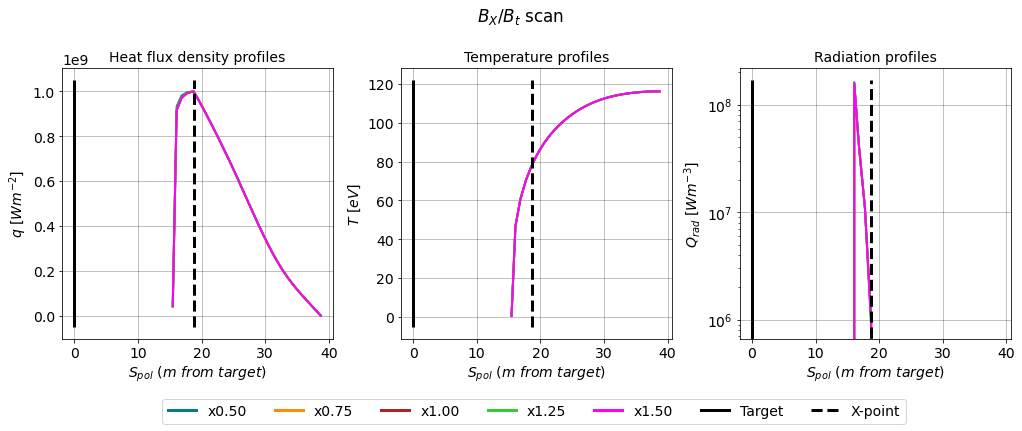

In [395]:
labels = {"cvar_trim":"$n_{u}\ (m^{-3})$", "crel_trim":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
labels = {"cvar":"$n_{u}\ (m^{-3})$", "crel":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
colors = mike_cmap(5)
store = lmscan
cvar = "density"

for g in range(3):

    fig, axes = plt.subplots(1,3,figsize = (17,5))
    fig.suptitle(names[g], y = 1.05)
    fig.subplots_adjust(wspace=0.25)
    for k, param in enumerate(["Qprofiles", "Tprofiles", "Rprofiles"]):

        # fig.suptitle("Density scan of front profiles")
        ax = axes[k]
        ax.set_title(profile_names[param])

        for i, case in enumerate(scales[g]):
            d = datas[g][case]
            o = stores[g][cvar][case]
            point = -3
            if g == 0:
                ax.plot(o["Sprofiles"][point], o[param][point], linewidth = 2,  color = colors[i], label = "x{:.2f}".format(case))
            else:
                ax.plot(o["Sprofiles"][point], o[param][point], linewidth = 2,  color = colors[i])

        ylim = ax.get_ylim()
        if g != 0:
            ax.vlines(d["S"][d["Xpoint"]], ylim[0], ylim[1], color = "black", linestyle = "dashed", zorder = 100)
        
        ax.vlines(0, ylim[0], ylim[1], color = "black", linestyle = "solid", zorder = 100)

        if param == "Rprofiles":
            ax.set_yscale("log")

        ax.grid(color ="black", alpha = 0.3)
        ax.set_xlabel("$S_{pol}\ (m\ from\ target)$")
        ax.set_ylabel(profile_labels[param])
        ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0f}"))
        
    legend_elements = []
    
    for i, case in enumerate(scales[g]):
        legend_elements.append(mpl.lines.Line2D([0], [0], color=colors[i], lw=3, label = "x{:.2f}".format(case)))
    
    legend_elements.append(mpl.lines.Line2D([0], [0], color="black", linestyle = "solid", lw=3, label='Target'))
    
    if g != 0:
        legend_elements.append(mpl.lines.Line2D([0], [0], color="black", linestyle = "dashed", lw=3, label='X-point'))

    if g != 0:
        fig.legend(handles = legend_elements, ncol = 7, bbox_to_anchor =(0.82,-0.02))
    else:
        fig.legend(handles = legend_elements, ncol = 7, bbox_to_anchor =(0.78,-0.02))


## Front locations

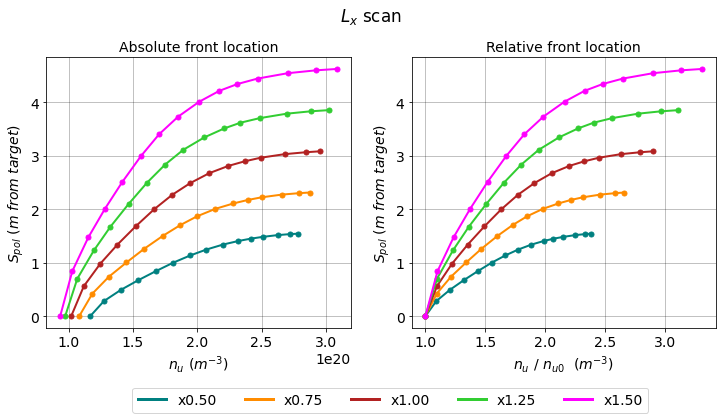

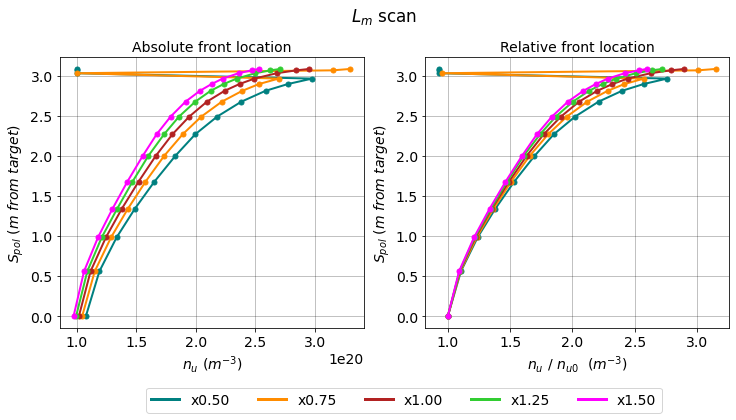

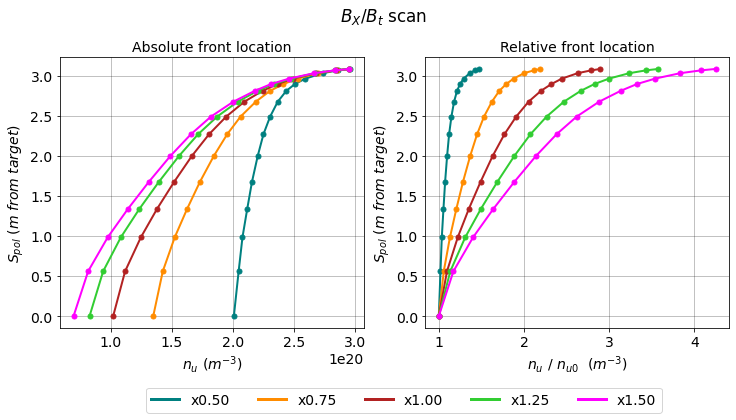

In [396]:
labels = {"cvar_trim":"$n_{u}\ (m^{-3})$", "crel_trim":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
labels = {"cvar":"$n_{u}\ (m^{-3})$", "crel":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
cvar = "density"

g = 0
for g in range(3):
    
    store = stores[g]
    colors = mike_cmap(5)
    fig, axes = plt.subplots(1,2, figsize = (12,5))
    for k, basis in enumerate(["cvar", "crel"]):
        fig.suptitle(names[g], y = 1.02)
        ax = axes[0] 
        for i, case in enumerate(scales[g]):
            o = store[cvar][case]
            axes[k].plot(o[basis], o["SpolPlot"],  marker = "o", markersize = 5, linewidth = 2, color = colors[i])
            axes[k].set_xlabel(labels[basis])
        for ax in axes:
            ax.grid(color ="black", alpha = 0.3)

            ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")      
        axes[0].set_title("Absolute front location")
        axes[1].set_title("Relative front location")


    legend_elements = [] 
    for i, case in enumerate(scales[g]):
        legend_elements.append(mpl.lines.Line2D([0], [0], color=colors[i], lw=3, label = "x{:.2f}".format(case)))

    fig.legend(handles = legend_elements, ncol = 5, bbox_to_anchor =(0.83,-0.02))

## Threshold/window

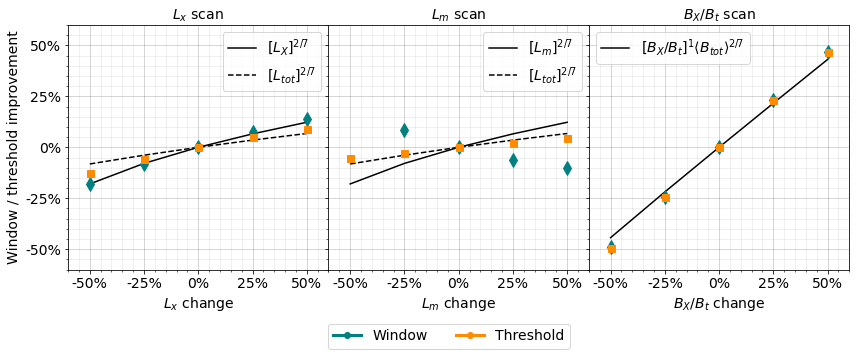

In [402]:
g = 0

thresholds = dict()
windows = dict()
w_ratio = dict()
t_ratio = dict()

for g in range(3):
    
    thresholds[g] = []
    windows[g] = []

    for i, case in enumerate(scales[g]):
        o = stores[g][cvar][case]
        Xpoint = datas[g][case]["Xpoint"]
        windows[g].append(o["window_ratio"])
        thresholds[g].append(o["threshold"])

    windows[g] = np.array(windows[g])
    thresholds[g] = np.array(thresholds[g])

    w_ratio[g] = windows[g]/windows[g][2]
    t_ratio[g] = 1/ (thresholds[g]/thresholds[g][2])

# for i, case in enumerate(scales[g]):
    # print(" || W ratio: {:.2f} || T ratio: {:.2f} || W/T: {:.2f}".format(w_ratio[g][i], t_ratio[g][i], w_ratio[g][i]/t_ratio[g][i]))
    
fig, axes = plt.subplots(1, 3, figsize=(14,4.5), sharey = True)
fig.subplots_adjust(wspace=0)
for g in range(3):
    ax = axes[g]
    ax.set_title(names[g])
    ax.plot(scales[g]-1, w_ratio[g]-1, marker = "d", linestyle = "solid", color = colors[0], markersize = 10, linewidth = 0)
    ax.plot(scales[g]-1, t_ratio[g]-1, marker = "s", linestyle = "dashed", color = colors[1], markersize = 7, linewidth = 0)
    ax.set_xlabel("{} change".format(names[g].replace(" scan","")))
    
    ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
    ax.xaxis.set_major_locator(MultipleLocator(0.25))
    ax.yaxis.set_major_locator(MultipleLocator(0.25))
    ax.xaxis.set_minor_locator(MultipleLocator(0.05))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.grid(which="major", color = "black", alpha = 0.2)
    ax.grid(which="minor", color = "black", alpha = 0.075)
    ax.set_ylim(-0.60,0.60)
    ax.set_xlim(-0.60, 0.60)
    
zorder_scalings = 0
linewidth_scalings = 1.5
axes[0].plot(list_Lx_scales-1, list_Lx_scales**(2/7)-1, color = "black", linestyle = "solid", linewidth = linewidth_scalings, zorder = zorder_scalings,
            label = "$[L_X]^{2/7}$")
axes[0].plot(list_Lx_scales-1, Ltot_scales[1]**(2/7)-1, color = "black", linestyle = "dashed", linewidth = linewidth_scalings, zorder = zorder_scalings,
            label = "$[L_{tot}]^{2/7}$")
axes[1].plot(list_Lm_scales-1, list_Lm_scales**(2/7)-1, color = "black", linestyle = "solid", linewidth = linewidth_scalings, zorder = zorder_scalings,
            label = "$[L_m]^{2/7}$")
axes[1].plot(list_Lm_scales-1, Ltot_scales[1]**(2/7)-1, color = "black", linestyle = "dashed", linewidth = linewidth_scalings, zorder = zorder_scalings,
            label = "$[L_{tot}]^{2/7}$")
axes[2].plot(list_Lm_scales-1, list_BxBt_scales*(Bavg_scales[2]**(2/7))-1, color = "black", linestyle = "solid", linewidth = linewidth_scalings, zorder = zorder_scalings,
            label = r"$[B_X/B_t]^{1} {\langle}B_{tot}{\rangle}^{2/7}$")

for ax in axes:
    ax.legend()
axes[0].set_ylabel("Window / threshold improvement")
legend_elements = [
    mpl.lines.Line2D([0], [0], color=colors[0], lw=3, marker = "o", label = "Window"),
    mpl.lines.Line2D([0], [0], color=colors[1], lw=3, marker = "o", label = "Threshold")]

fig.legend(handles = legend_elements, ncol = 5, bbox_to_anchor =(0.63,-0.02))

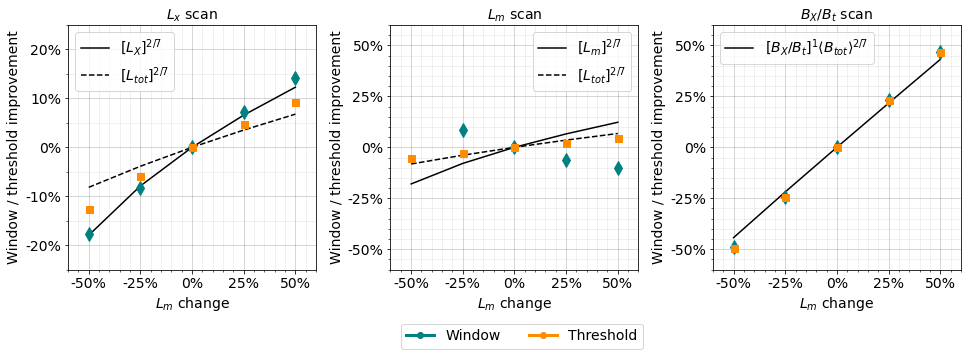

In [398]:
g = 0

thresholds = dict()
windows = dict()
w_ratio = dict()
t_ratio = dict()

for g in range(3):
    
    thresholds[g] = []
    windows[g] = []

    for i, case in enumerate(scales[g]):
        o = stores[g][cvar][case]
        Xpoint = datas[g][case]["Xpoint"]
        windows[g].append(o["window_ratio"])
        thresholds[g].append(o["threshold"])

    windows[g] = np.array(windows[g])
    thresholds[g] = np.array(thresholds[g])

    w_ratio[g] = windows[g]/windows[g][2]
    t_ratio[g] = 1/ (thresholds[g]/thresholds[g][2])

# for i, case in enumerate(scales[g]):
    # print(" || W ratio: {:.2f} || T ratio: {:.2f} || W/T: {:.2f}".format(w_ratio[g][i], t_ratio[g][i], w_ratio[g][i]/t_ratio[g][i]))
    
fig, axes = plt.subplots(1, 3, figsize=(16,4.5), sharey = False)
fig.subplots_adjust(wspace=.3)
for g in range(3):
    ax = axes[g]
    ax.set_title(names[g])
    ax.plot(scales[g]-1, w_ratio[g]-1, marker = "d", linestyle = "solid", color = colors[0], markersize = 10, linewidth = 0)
    ax.plot(scales[g]-1, t_ratio[g]-1, marker = "s", linestyle = "dashed", color = colors[1], markersize = 7, linewidth = 0)
    ax.set_xlabel("$L_m$ change")
    
    ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
    ax.xaxis.set_major_locator(MultipleLocator(0.25))
    ax.yaxis.set_major_locator(MultipleLocator(0.25))
    ax.xaxis.set_minor_locator(MultipleLocator(0.05))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.grid(which="major", color = "black", alpha = 0.2)
    ax.grid(which="minor", color = "black", alpha = 0.075)
    ax.set_ylim(-0.60,0.60)
    ax.set_xlim(-0.60, 0.60)
    
axes[0].set_ylim(-0.25, 0.25)
axes[0].yaxis.set_major_locator(MultipleLocator(0.1))
    
zorder_scalings = 0
linewidth_scalings = 1.5
axes[0].plot(list_Lx_scales-1, list_Lx_scales**(2/7)-1, color = "black", linestyle = "solid", linewidth = linewidth_scalings, zorder = zorder_scalings,
            label = "$[L_X]^{2/7}$")
axes[0].plot(list_Lx_scales-1, Ltot_scales[1]**(2/7)-1, color = "black", linestyle = "dashed", linewidth = linewidth_scalings, zorder = zorder_scalings,
            label = "$[L_{tot}]^{2/7}$")
axes[1].plot(list_Lm_scales-1, list_Lm_scales**(2/7)-1, color = "black", linestyle = "solid", linewidth = linewidth_scalings, zorder = zorder_scalings,
            label = "$[L_m]^{2/7}$")
axes[1].plot(list_Lm_scales-1, Ltot_scales[1]**(2/7)-1, color = "black", linestyle = "dashed", linewidth = linewidth_scalings, zorder = zorder_scalings,
            label = "$[L_{tot}]^{2/7}$")
axes[2].plot(list_Lm_scales-1, list_BxBt_scales*(Bavg_scales[2]**(2/7))-1, color = "black", linestyle = "solid", linewidth = linewidth_scalings, zorder = zorder_scalings,
            label = r"$[B_X/B_t]^{1} {\langle}B_{tot}{\rangle}^{2/7}$")

for ax in axes:
    ax.legend()
    ax.set_ylabel("Window / threshold improvement")
legend_elements = [
    mpl.lines.Line2D([0], [0], color=colors[0], lw=3, marker = "o", label = "Window"),
    mpl.lines.Line2D([0], [0], color=colors[1], lw=3, marker = "o", label = "Threshold")]

fig.legend(handles = legend_elements, ncol = 5, bbox_to_anchor =(0.63,-0.02))

# Run with power

## Lm

In [475]:
list_cvars = ["power"]

# list_designs = ["SPR38_hiq"]


store = dict()

    
for cvar in list_cvars:
    store[cvar] = dict()
    print(f"Variable {cvar}...", end = "")

    for case in list_Lm_scales:
        print("Case {}...".format(case))

        d = d_lmscale[case].copy()
        constants = constants_default.copy()
        radios = radios_default.copy()
        constants["XpointIndex"] = d["Xpoint"] # Index of Xpoint   
        constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
        SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 15)
        indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange] 
        store[cvar][case] = LRBv21(constants,radios,d["S"],d["Spol"], indexRange, 
                                            Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 0, qradial_fix2 = False,
                                            control_variable = cvar)

lmscan = copy.deepcopy(store)

Variable power...Case 0.5...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 16.9 seconds
Case 0.75...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 15.8 seconds
Case 1.0...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 17.8 seconds
Case 1.25...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 17.9 seconds
Case 1.5...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 16.8 seconds


## Lx

In [476]:
list_cvars = ["power"]

# list_designs = ["SPR38_hiq"]


store = dict()

    
for cvar in list_cvars:
    store[cvar] = dict()
    print(f"Variable {cvar}...", end = "")

    for case in list_Lm_scales:
        print("Case {}...".format(case))

        d = d_lxscale[case].copy()
        constants = constants_default.copy()
        radios = radios_default.copy()
        constants["XpointIndex"] = d["Xpoint"] # Index of Xpoint   
        constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
        SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 15)
        indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange] 
        store[cvar][case] = LRBv21(constants,radios,d["S"],d["Spol"], indexRange, 
                                            Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 0, qradial_fix2 = False,
                                            control_variable = cvar)

lxscan = copy.deepcopy(store)

Variable power...Case 0.5...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 16.0 seconds
Case 0.75...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 17.5 seconds
Case 1.0...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 17.8 seconds
Case 1.25...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 17.3 seconds
Case 1.5...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 17.7 seconds


## BxBt

In [477]:
list_cvars = ["power"]
store = dict()
for cvar in list_cvars:
    store[cvar] = dict()
    print(f"Variable {cvar}...", end = "")

    for case in list_BxBt_scales:
        print("Case {}...".format(case))

        d = d_BxBtscale[case].copy()
        constants = constants_default.copy()
        radios = radios_default.copy()
        constants["XpointIndex"] = d["Xpoint"] # Index of Xpoint   
        constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
        SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 15)
        indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange] 
        store[cvar][case] = LRBv21(constants,radios,d["S"],d["Spol"], indexRange, 
                                            Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 0, qradial_fix2 = False,
                                            control_variable = cvar)

bxbtscan = copy.deepcopy(store)

Variable power...Case 0.5...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 17.1 seconds
Case 0.75...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 17.6 seconds
Case 1.0...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 17.4 seconds
Case 1.25...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 18.0 seconds
Case 1.5...
Solving...0...33...58...79...99...118...134...147...158...166...171...175...179...181...182...Complete in 17.0 seconds


# ALL PP

## Prepare data

In [478]:
scales = [list_Lx_scales, list_Lm_scales, list_BxBt_scales]
stores = [lxscan, lmscan, bxbtscan]
datas = [d_lxscale, d_lmscale, d_BxBtscale]
names = ["$L_x$ scan", "$L_m$ scan", "$B_X/B_t$ scan"]
colors = mike_cmap(6)
Bavg_scales = [None]*3
Ltot_scales = [None]*3

for g in range(3):

    Bavgs = []
    Ltots = []
    for i, case in enumerate(scales[g]):
        d = datas[g][case]
        Bavgs.append(np.mean(d["Btot"][:d["Xpoint"]]))
        Ltots.append(d["S"][-1])

    Bavg_scales[g] = np.array(Bavgs) / Bavgs[2]
    Ltot_scales[g] = np.array(Ltots) / Ltots[2]

studies["power"] = copy.deepcopy(stores)

In [517]:
stores = studies["power"]
cvar = "power"

## Geometry

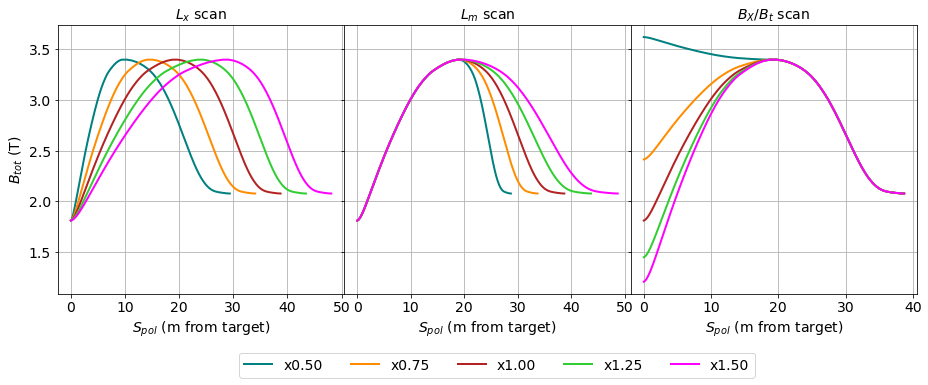

In [449]:
# d_lmscale[0] = copy.deepcopy(data["ou"])

fig, axes = plt.subplots(1, 3, figsize=(14*1.1,4.5*1.1), sharey = True)
fig.subplots_adjust(wspace=0)
scale = scales[0]
for g in range(3):

    ax = axes[g]
   
    store = stores[g]
    for i, case in enumerate(scales[g]):
        d = datas[g][case]
        if g == 0:
            ax.plot(d["S"], d["Btot"], label = "x{:.2f}".format(case), color = colors[i], linewidth = 2)
        else: 
            ax.plot(d["S"], d["Btot"], color = colors[i], linewidth = 2)
    ax.set_title(names[g])
    ax.set_xlabel("$S_{pol}$ (m from target)")
axes[0].set_ylabel("$B_{tot}$ (T)")
fig.legend(ncol = 6, bbox_to_anchor =(0.76,-0.02))




## Profiles

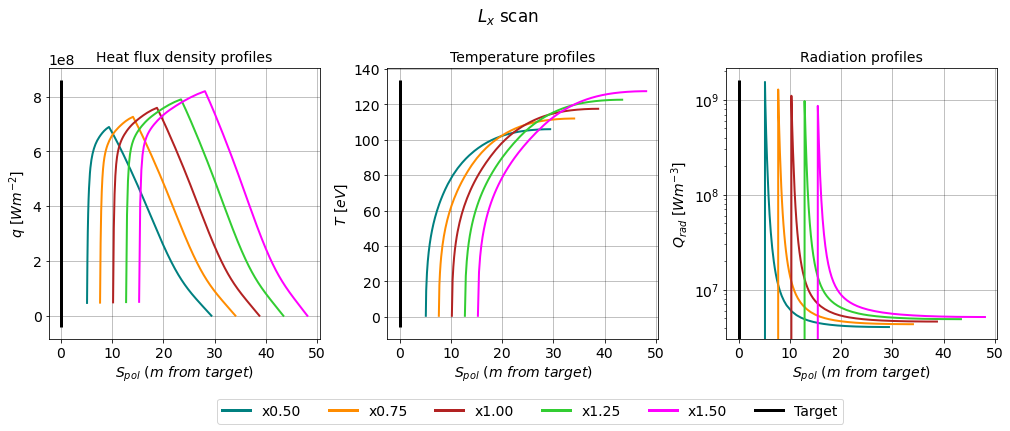

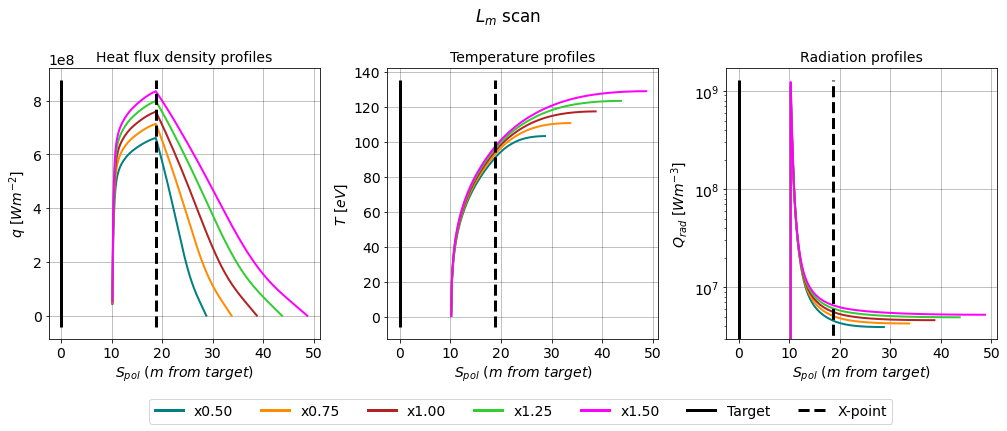

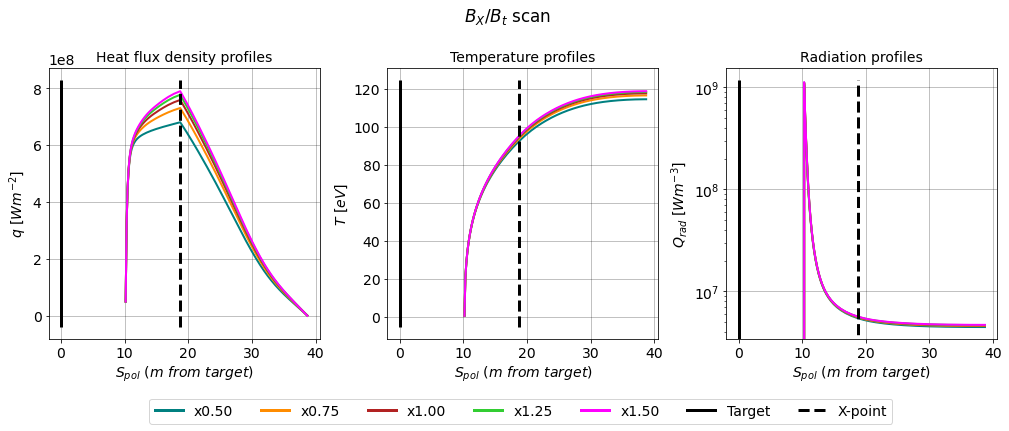

In [450]:
labels = {"cvar_trim":"$n_{u}\ (m^{-3})$", "crel_trim":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
labels = {"cvar":"$n_{u}\ (m^{-3})$", "crel":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
colors = mike_cmap(5)
cvar = "power"

for g in range(3):

    fig, axes = plt.subplots(1,3,figsize = (17,5))
    fig.suptitle(names[g], y = 1.05)
    fig.subplots_adjust(wspace=0.25)
    for k, param in enumerate(["Qprofiles", "Tprofiles", "Rprofiles"]):

        # fig.suptitle("Density scan of front profiles")
        ax = axes[k]
        ax.set_title(profile_names[param])

        for i, case in enumerate(scales[g]):
            d = datas[g][case]
            o = stores[g][cvar][case]
            point = -7
            if g == 0:
                ax.plot(o["Sprofiles"][point], o[param][point], linewidth = 2,  color = colors[i], label = "x{:.2f}".format(case))
            else:
                ax.plot(o["Sprofiles"][point], o[param][point], linewidth = 2,  color = colors[i])

        ylim = ax.get_ylim()
        if g != 0:
            ax.vlines(d["S"][d["Xpoint"]], ylim[0], ylim[1], color = "black", linestyle = "dashed", zorder = 100)
        
        ax.vlines(0, ylim[0], ylim[1], color = "black", linestyle = "solid", zorder = 100)

        if param == "Rprofiles":
            ax.set_yscale("log")

        ax.grid(color ="black", alpha = 0.3)
        ax.set_xlabel("$S_{pol}\ (m\ from\ target)$")
        ax.set_ylabel(profile_labels[param])
        ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0f}"))
        
    legend_elements = []
    
    for i, case in enumerate(scales[g]):
        legend_elements.append(mpl.lines.Line2D([0], [0], color=colors[i], lw=3, label = "x{:.2f}".format(case)))
    
    legend_elements.append(mpl.lines.Line2D([0], [0], color="black", linestyle = "solid", lw=3, label='Target'))
    
    if g != 0:
        legend_elements.append(mpl.lines.Line2D([0], [0], color="black", linestyle = "dashed", lw=3, label='X-point'))

    if g != 0:
        fig.legend(handles = legend_elements, ncol = 7, bbox_to_anchor =(0.82,-0.02))
    else:
        fig.legend(handles = legend_elements, ncol = 7, bbox_to_anchor =(0.78,-0.02))


In [451]:
stores[2]["power"][0.5]["constants"]

{'gamma_sheath': 7,
 'qpllu0': 1000000000.0,
 'nu': 1e+20,
 'nu0': 1e+20,
 'cz0': 0.02,
 'kappa0': 2500,
 'mi': 3e-27,
 'echarge': 1.6000000000000002e-19,
 'Tt': 0.5,
 'Lfunc': <function AnalyticCoolingCurves.LfuncKallenbachAr(T)>,
 'alpha': 1000,
 'XpointIndex': 183,
 'B': <scipy.interpolate.interpolate.interp1d at 0x1cb91491860>}

## Front locations

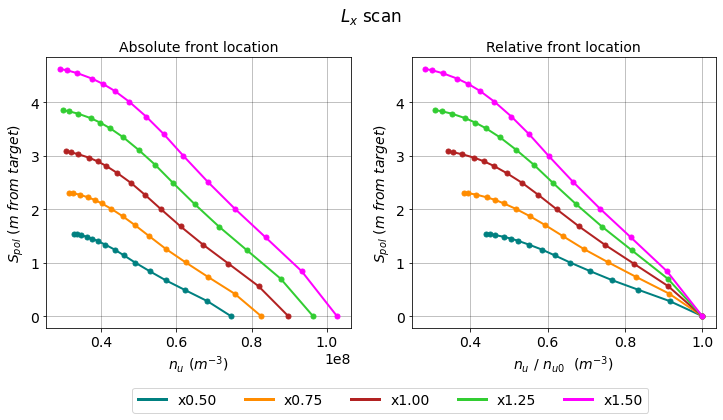

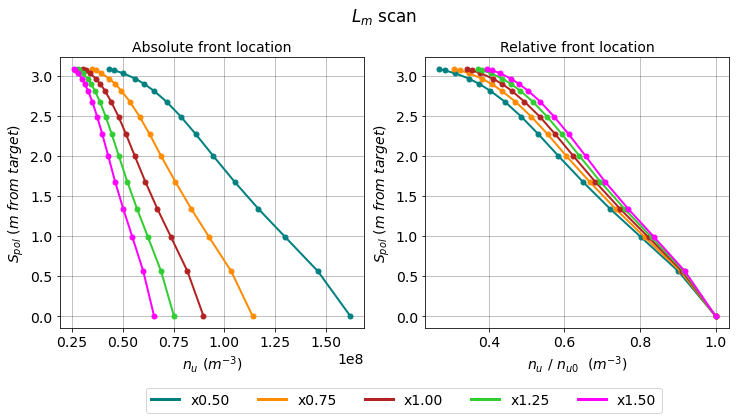

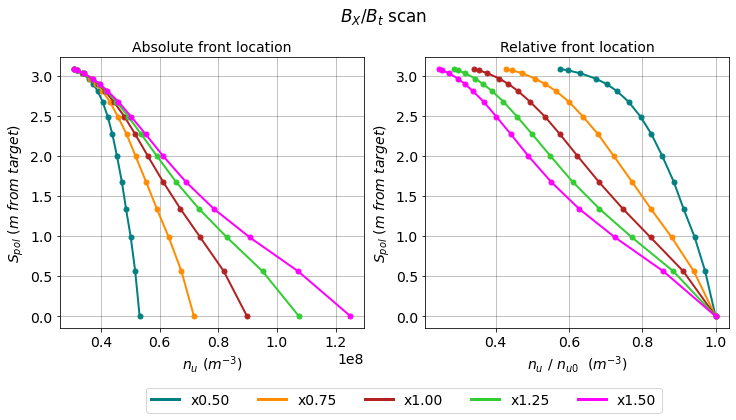

In [452]:
labels = {"cvar_trim":"$n_{u}\ (m^{-3})$", "crel_trim":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
labels = {"cvar":"$n_{u}\ (m^{-3})$", "crel":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
cvar = "power"

g = 0
for g in range(3):
    
    store = stores[g]
    colors = mike_cmap(5)
    fig, axes = plt.subplots(1,2, figsize = (12,5))
    for k, basis in enumerate(["cvar", "crel"]):
        fig.suptitle(names[g], y = 1.02)
        ax = axes[0] 
        for i, case in enumerate(scales[g]):
            o = store[cvar][case]
            axes[k].plot(o[basis], o["SpolPlot"],  marker = "o", markersize = 5, linewidth = 2, color = colors[i])
            axes[k].set_xlabel(labels[basis])
        for ax in axes:
            ax.grid(color ="black", alpha = 0.3)

            ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")      
        axes[0].set_title("Absolute front location")
        axes[1].set_title("Relative front location")


    legend_elements = [] 
    for i, case in enumerate(scales[g]):
        legend_elements.append(mpl.lines.Line2D([0], [0], color=colors[i], lw=3, label = "x{:.2f}".format(case)))

    fig.legend(handles = legend_elements, ncol = 5, bbox_to_anchor =(0.83,-0.02))

## Threshold/window

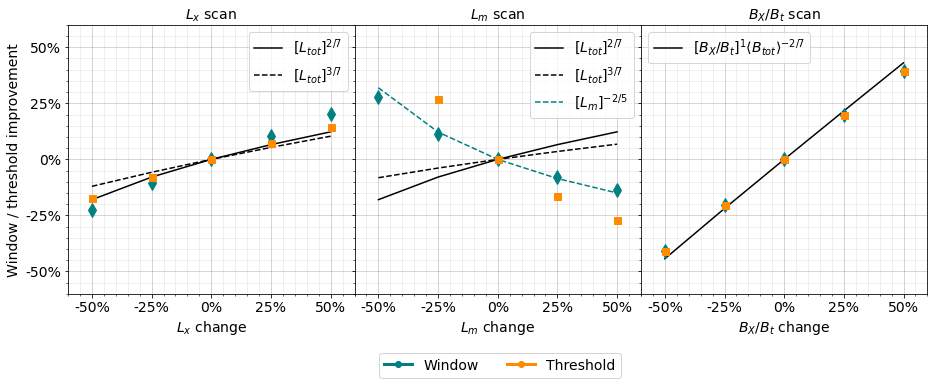

In [519]:
g = 0

thresholds = dict()
windows = dict()
w_ratio = dict()
t_ratio = dict()

for g in range(3):
    
    thresholds[g] = []
    windows[g] = []

    for i, case in enumerate(scales[g]):
        o = stores[g][cvar][case]
        Xpoint = datas[g][case]["Xpoint"]
        windows[g].append(o["window_ratio"])
        thresholds[g].append(o["threshold"])

    windows[g] = np.array(windows[g])
    thresholds[g] = np.array(thresholds[g])

    w_ratio[g] = 1/(windows[g]/windows[g][2])
    t_ratio[g] = (thresholds[g]/thresholds[g][2])

# for i, case in enumerate(scales[g]):
    # print(" || W ratio: {:.2f} || T ratio: {:.2f} || W/T: {:.2f}".format(w_ratio[g][i], t_ratio[g][i], w_ratio[g][i]/t_ratio[g][i]))

s = 1.1
fig, axes = plt.subplots(1, 3, figsize=(14*s,4.5*s), sharey = True)
fig.subplots_adjust(wspace=0)
for g in range(3):
    ax = axes[g]
    ax.set_title(names[g])
    ax.plot(scales[g]-1, w_ratio[g]-1, marker = "d", linestyle = "solid", color = colors[0], markersize = 10, linewidth = 0)
    ax.plot(scales[g]-1, t_ratio[g]-1, marker = "s", linestyle = "dashed", color = colors[1], markersize = 7, linewidth = 0)
    ax.set_xlabel("{} change".format(names[g].replace(" scan","")))
    
    ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
    ax.xaxis.set_major_locator(MultipleLocator(0.25))
    ax.yaxis.set_major_locator(MultipleLocator(0.25))
    ax.xaxis.set_minor_locator(MultipleLocator(0.05))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.grid(which="major", color = "black", alpha = 0.2)
    ax.grid(which="minor", color = "black", alpha = 0.075)
    ax.set_ylim(-0.60,0.60)
    ax.set_xlim(-0.60, 0.60)
    
zorder_scalings = 0
linewidth_scalings = 1.5
axes[0].plot(list_Lx_scales-1, list_Lx_scales**(2/7)-1, color = "black", linestyle = "solid", linewidth = linewidth_scalings, zorder = zorder_scalings,
            label = "$[L_{tot}]^{2/7}$")
axes[0].plot(list_Lx_scales-1, Ltot_scales[1]**(3/7)-1, color = "black", linestyle = "dashed", linewidth = linewidth_scalings, zorder = zorder_scalings,
            label = "$[L_{tot}]^{3/7}$")


axes[1].plot(list_Lm_scales-1, list_Lm_scales**(2/7)-1, color = "black", linestyle = "solid", linewidth = linewidth_scalings, zorder = zorder_scalings,
            label = "$[L_{tot}]^{2/7}$")
axes[1].plot(list_Lm_scales-1, Ltot_scales[1]**(2/7)-1, color = "black", linestyle = "dashed", linewidth = linewidth_scalings, zorder = zorder_scalings,
            label = "$[L_{tot}]^{3/7}$")

axes[2].plot(list_Lm_scales-1, list_BxBt_scales*(Bavg_scales[2]**(2/7))-1, color = "black", linestyle = "solid", linewidth = linewidth_scalings, zorder = zorder_scalings,
            label = r"$[B_X/B_t]^{1} {\langle}B_{tot}{\rangle}^{-2/7}$")
axes[1].plot(list_Lm_scales-1, list_Lm_scales**(-2/5)-1, color = "teal", linestyle = "dashed", linewidth = linewidth_scalings, zorder = zorder_scalings,
            label = "$[L_{m}]^{-2/5}$")

for ax in axes:
    ax.legend()
axes[0].set_ylabel("Window / threshold improvement")
legend_elements = [
    mpl.lines.Line2D([0], [0], color=colors[0], lw=3, marker = "o", label = "Window"),
    mpl.lines.Line2D([0], [0], color=colors[1], lw=3, marker = "o", label = "Threshold")]

fig.legend(handles = legend_elements, ncol = 5, bbox_to_anchor =(0.63,-0.02))

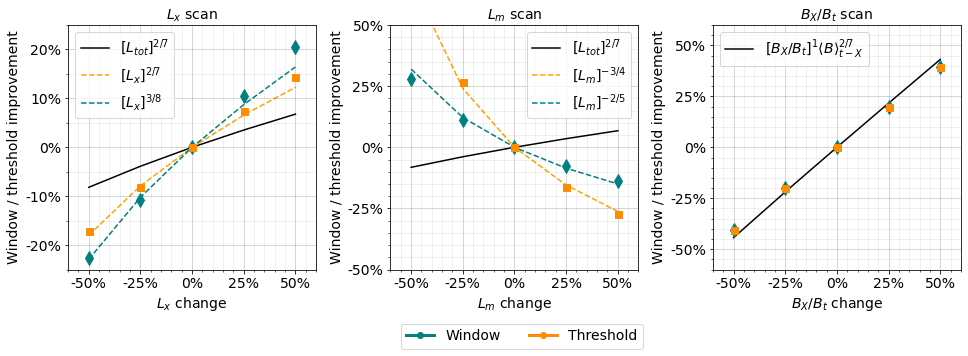

In [526]:
g = 0

thresholds = dict()
windows = dict()
w_ratio = dict()
t_ratio = dict()

for g in range(3):
    
    thresholds[g] = []
    windows[g] = []

    for i, case in enumerate(scales[g]):
        o = stores[g][cvar][case]
        Xpoint = datas[g][case]["Xpoint"]
        windows[g].append(o["window_ratio"])
        thresholds[g].append(o["threshold"])

    windows[g] = np.array(windows[g])
    thresholds[g] = np.array(thresholds[g])

    w_ratio[g] = 1/(windows[g]/windows[g][2])
    t_ratio[g] = (thresholds[g]/thresholds[g][2])

# for i, case in enumerate(scales[g]):
    # print(" || W ratio: {:.2f} || T ratio: {:.2f} || W/T: {:.2f}".format(w_ratio[g][i], t_ratio[g][i], w_ratio[g][i]/t_ratio[g][i]))
    
fig, axes = plt.subplots(1, 3, figsize=(16,4.5), sharey = False)
fig.subplots_adjust(wspace=.3)
for g in range(3):
    ax = axes[g]
    ax.set_title(names[g])
    ax.plot(scales[g]-1, w_ratio[g]-1, marker = "d", linestyle = "solid", color = colors[0], markersize = 10, linewidth = 0)
    ax.plot(scales[g]-1, t_ratio[g]-1, marker = "s", linestyle = "dashed", color = colors[1], markersize = 7, linewidth = 0)
    ax.set_xlabel("{} change".format(names[g].replace(" scan","")))
    
    ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
    ax.xaxis.set_major_locator(MultipleLocator(0.25))
    ax.yaxis.set_major_locator(MultipleLocator(0.25))
    ax.xaxis.set_minor_locator(MultipleLocator(0.05))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.grid(which="major", color = "black", alpha = 0.2)
    ax.grid(which="minor", color = "black", alpha = 0.075)
    ax.set_ylim(-0.60,0.60)
    ax.set_xlim(-0.60, 0.60)
    
axes[0].set_ylim(-0.25, 0.25)
axes[1].set_ylim(-0.50, 0.50)
axes[0].yaxis.set_major_locator(MultipleLocator(0.1))
    
zorder_scalings = 0
linewidth_scalings = 1.5
scale = 3/7
axes[0].plot(list_Lx_scales-1, Ltot_scales[1]**(2/7)-1, color = "black", linestyle = "solid", linewidth = linewidth_scalings, zorder = zorder_scalings,
            label = "$[L_{tot}]^{2/7}$")
axes[0].plot(list_Lx_scales-1, list_Lx_scales**(2/7)-1, color = "orange", linestyle = "dashed", linewidth = linewidth_scalings, zorder = zorder_scalings,
            label = "$[L_{x}]^{2/7}$")
axes[0].plot(list_Lx_scales-1,list_Lx_scales**(3/8)-1, color = "teal", linestyle = "dashed", linewidth = linewidth_scalings, zorder = zorder_scalings,
            label = "$[L_{x}]^{3/8}$")


axes[1].plot(list_Lm_scales-1, Ltot_scales[1]**(2/7)-1, color = "black", linestyle = "solid", linewidth = linewidth_scalings, zorder = zorder_scalings,
            label = "$[L_{tot}]^{2/7}$")
# axes[1].plot(list_Lm_scales-1, Ltot_scales[1]**(3/7)-1, color = "black", linestyle = "dashed", linewidth = linewidth_scalings, zorder = zorder_scalings,
#             label = "$[L_{tot}]^{3/7}$")

axes[1].plot(list_Lm_scales-1, list_Lm_scales**(-3/4)-1, color = "orange", linestyle = "dashed", linewidth = linewidth_scalings, zorder = zorder_scalings,
            label = "$[L_{m}]^{-3/4}$")
axes[1].plot(list_Lm_scales-1, list_Lm_scales**(-2/5)-1, color = "teal", linestyle = "dashed", linewidth = linewidth_scalings, zorder = zorder_scalings,
            label = "$[L_{m}]^{-2/5}$")

axes[2].plot(list_Lm_scales-1, list_BxBt_scales*(Bavg_scales[2]**(2/7))-1, color = "black", linestyle = "solid", linewidth = linewidth_scalings, zorder = zorder_scalings,
            label = r"$[B_X/B_t]^{1} {\langle}B{\rangle}^{2/7}_{t-X}$")



for ax in axes:
    ax.legend()
    ax.set_ylabel("Window / threshold improvement")
legend_elements = [
    mpl.lines.Line2D([0], [0], color=colors[0], lw=3, marker = "o", label = "Window"),
    mpl.lines.Line2D([0], [0], color=colors[1], lw=3, marker = "o", label = "Threshold")]

fig.legend(handles = legend_elements, ncol = 5, bbox_to_anchor =(0.63,-0.02))